# 🧠 AN2DL 2024/25 Homework 2


## 🌐 Connect Colab to Google Drive

Google Drive connection for the owner of the Drive folder

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/DeepL/DeepL Team/Homework 2/Matteo

Mounted at /gdrive
/gdrive/My Drive/DeepL/DeepL Team/Homework 2/Matteo


Google Drive connection for other team members

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/DeepL Team/Homework 2/Michele

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1XqCxOkXIFV81NU8IlltS38bM65k9N-bR/DeepL Team/Homework 2/Michele


## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os
from datetime import datetime

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
np.random.seed(42)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from scipy.ndimage import sobel

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

2.17.1
TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


## ⏳ Load the Data

### Data loading

In [ ]:
# Load image and label paths
print("Loading file paths ...")
image_paths = sorted([os.path.join('../NewDataset/data', f) for f in os.listdir('../NewDataset/data')])
label_paths = sorted([os.path.join('../NewDataset/labels', f) for f in os.listdir('../NewDataset/labels')])
print("File paths loaded!")

Loading file paths ...
File paths loaded!


In [ ]:
# Display some examples of paths
print("\nLast image paths:", image_paths[7500:])
print("Last label paths:", label_paths[7500:])


Last image paths: []
Last label paths: []


In [ ]:
category_map = {
        0: 0,  # Background
        1: 1,  # Soil
        2: 2,  # Bedrock
        3: 3,  # Sand
        4: 4,  # Big Rock
}

### Data splitting

In [ ]:
len(image_paths)

2505

In [ ]:
len(label_paths)

2505

In [ ]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data ...")
train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    image_paths, label_paths, test_size=205, random_state=seed
)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=300, random_state=seed
)
print("Data splitted!")

Splitting data ...
Data splitted!


In [ ]:
print(f"\nNumber of images ...")
print(f"Train     : {len(train_img)}")
print(f"Validation: {len(val_img)}")
print(f"Test      : {len(test_img)}")


Number of images ...
Train     : 2000
Validation: 300
Test      : 205


In [ ]:
# Ratio of the splitting
print(f"Ratio of the splitting: {len(train_img)/len(image_paths)*100} / {len(val_img)/len(image_paths)*100} / {len(test_img)/len(image_paths)*100}")

Ratio of the splitting: 79.84031936127745 / 11.976047904191617 / 8.183632734530939


In [ ]:
def load_single_image(image_path, label_path, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """
    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=1)  # Ensure 1 channel
    image = tf.image.resize(image, input_size)   # Resize to fixed size
    image = tf.cast(image, tf.float16) / 255.0

    # Read and preprocess the label
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)  # Ensure single channel
    label = tf.image.resize(label, input_size, method='bilinear')  # Resize to fixed size
    label = tf.cast(label, tf.int32)

    return image, label

In [ ]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

### Data inspection

In [ ]:
data = np.load("../Dataset/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape    : {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape    : (10022, 64, 128)


In [ ]:
print(f"Training mean    : {np.mean(X_train)}")
print(f"Test mean        : {np.mean(X_test)}")

print(f"\nTraining variance: {np.std(X_train)}")
print(f"Test variance    : {np.std(X_test)}")

Training mean    : 61.65502934355581
Test mean        : 60.74872153820189

Training variance: 28.019994789817915
Test variance    : 26.931112877416524


The differences are small but measurable. This could imply that the test set underwent augmentations or preprocessing that slightly reduced brightness and contrast compared to the training set.

### Augmentation

In [ ]:
@tf.function
def random_flip(image, label, seed=None):
    """Random horizontal and vertical flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    # Random vertical flip
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(label),
        lambda: label
    )
    # Random horizontal flip
    flip_prob = tf.random.uniform([], seed=seed + 1)  # New seed for independence
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

### Create datasets

In [ ]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        #dataset = dataset.map(
        #    lambda x, y: random_brightness_contrast(x, y, seed=seed+1),
        #    num_parallel_calls=tf.data.AUTOTUNE
        #)
    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# Set batch size for training
BATCH_SIZE = 64

In [ ]:
# Create the datasets
print("Creating datasets ...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

Creating datasets ...
Datasets created!


In [ ]:
# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape : {input_shape}")
    print("Images shape:", images.shape)
    print("Images dtype:", images.dtype)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break


Input shape : (64, 128, 1)
Images shape: (64, 64, 128, 1)
Images dtype: <dtype: 'float16'>
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(10, 2*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j], cmap='gray')
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

Visualising examples from the training set:


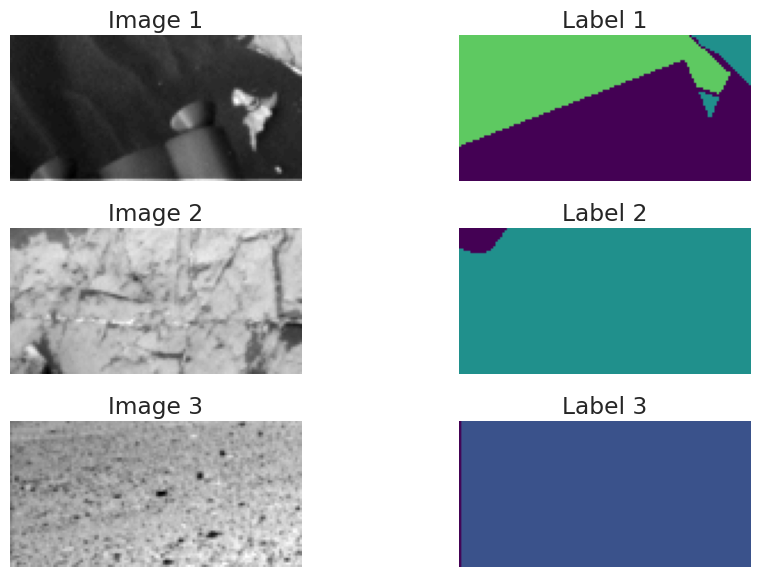

In [ ]:
# Visualize examples from the training set
print("Visualising examples from the training set:")
plot_sample_batch(train_dataset)

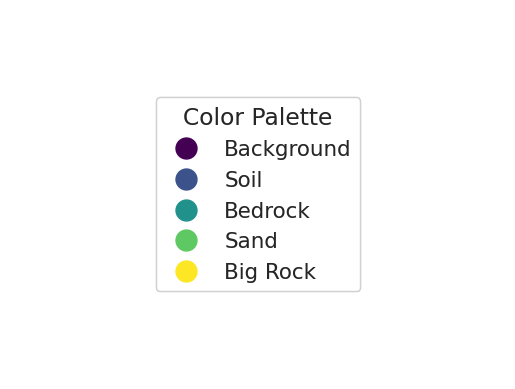

In [ ]:
num_classes = 5
# Create a discrete colormap using `viridis`
cmap = plt.cm.get_cmap('viridis', num_classes)

# Generate labels for the classes
class_labels = ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock']

# Create a scalar mappable to map colors to class indices
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.BoundaryNorm(boundaries=np.arange(num_classes + 1) - 0.5, ncolors=num_classes))

# Plot the legend
fig, ax = plt.subplots()
legend = ax.legend(
    handles=[plt.Line2D([0], [0], marker='o', color=cmap(i / num_classes), linestyle='', markersize=15) for i in range(num_classes)],
    labels=class_labels,
    loc='center',
    title="Color Palette"
)
ax.add_artist(legend)
ax.axis('off')  # No axis needed

plt.show()

## 🛠️ Train and Save the Model

In [ ]:
# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

### 🖌 Design of the model

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name='', dropout_rate=0.0):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    if dropout_rate > 0.0:
        x = tfkl.Dropout(dropout_rate, name=name + 'dropout')(x)

    # Return the transformed tensor
    return x

In [ ]:
def cross_branch_attention(input_tensors, filters, name=''):
    # Concatenate features from different branches
    concatenated = tfkl.Concatenate(name=name + 'concat')(input_tensors)

    # Attention mechanism
    attention = tfkl.Conv2D(filters, kernel_size=1, activation='sigmoid', name=name + 'attention')(concatenated)

    # Apply attention to each branch
    scaled_tensors = [tfkl.Multiply(name=name + f'scale_branch{i}')([branch, attention])
                      for i, branch in enumerate(input_tensors)]

    # Sum the scaled branches
    fused_output = tfkl.Add(name=name + 'fuse')(scaled_tensors)

    return fused_output

In [ ]:
def global_context_module(input_tensor, filters, activation='relu', name=''):
    # Global average pooling
    global_context = tfkl.GlobalAveragePooling2D(name=name + 'gap')(input_tensor)
    global_context = tfkl.Dense(filters, activation='sigmoid', name=name + 'context_dense')(global_context)

    # Reshape and scale input tensor
    global_context = tfkl.Reshape((1, 1, filters), name=name + 'reshape')(global_context)
    scaled_input = tfkl.Multiply(name=name + 'scale')([input_tensor, global_context])

    return scaled_input

In [ ]:
def squeeze_and_excitation(input_tensor, reduction_ratio=16, name=''):
    filters = input_tensor.shape[-1]
    se = tfkl.GlobalAveragePooling2D(name=name + 'se_gap')(input_tensor)
    se = tfkl.Dense(filters // reduction_ratio, activation='relu', name=name + 'se_reduce')(se)
    se = tfkl.Dense(filters, activation='sigmoid', name=name + 'se_expand')(se)
    se = tfkl.Reshape((1, 1, filters), name=name + 'se_reshape')(se)

    # Scale the input tensor
    scaled_input = tfkl.Multiply(name=name + 'se_scale')([input_tensor, se])
    return scaled_input

In [ ]:
def advanced_bottleneck_with_residual(input_tensor, filters, name=''):
    # Parallel dilated convolutions
    branch1 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=1, padding='same', name=name + 'dilated1')(input_tensor)
    branch2 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=2, padding='same', name=name + 'dilated2')(input_tensor)
    branch3 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=3, padding='same', name=name + 'dilated3')(input_tensor)

    # Cross-branch attention
    attention_output = cross_branch_attention([branch1, branch2, branch3], filters, name=name + 'cross_attention')

    # Global context enhancement
    context_output = global_context_module(attention_output, filters, name=name + 'context')

    # Squeeze-and-Excitation
    enhanced_features = squeeze_and_excitation(context_output, name=name + 'se')

    # Residual connection: ensure input matches the output shape using a 1x1 convolution
    input_residual = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + 'conv_residual')(input_tensor)

    # Add residual connection
    output = tfkl.Add(name=name + 'residual_add')([input_residual, enhanced_features])

    return output

In [ ]:
def get_unet_model_with_supervision(input_shape=(64, 128, 1), num_classes=5, seed=42, name_prefix=""):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name=name_prefix + 'input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name=name_prefix + 'down_block1_')
    d1 = tfkl.MaxPooling2D(name=name_prefix + 'maxpool1')(down_block_1)

    down_block_2 = unet_block(d1, 64, name=name_prefix + 'down_block2_', dropout_rate=0.1)
    d2 = tfkl.MaxPooling2D(name=name_prefix + 'maxpool2')(down_block_2)

    down_block_3 = unet_block(d2, 128, name=name_prefix + 'down_block3_', dropout_rate=0.2)
    d3 = tfkl.MaxPooling2D(name=name_prefix + 'maxpool3')(down_block_3)

    # Bottleneck
    bottleneck = advanced_bottleneck_with_residual(d3, 256, name=name_prefix + 'bottleneck')

    # Upsampling path with auxiliary outputs
    u1 = tfkl.UpSampling2D(name=name_prefix + 'upsample1')(bottleneck)
    u1 = tfkl.Concatenate(name=name_prefix + 'concat1')([u1, down_block_3])
    u1 = unet_block(u1, 128, name=name_prefix + 'up_block1_')

    aux_output1 = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax",
                              name=name_prefix + 'aux_output1')(u1)

    u2 = tfkl.UpSampling2D(name=name_prefix + 'upsample2')(u1)
    u2 = tfkl.Concatenate(name=name_prefix + 'concat2')([u2, down_block_2])
    u2 = unet_block(u2, 64, name=name_prefix + 'up_block2_', dropout_rate=0.3)

    aux_output2 = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax",
                              name=name_prefix + 'aux_output2')(u2)

    u3 = tfkl.UpSampling2D(name=name_prefix + 'upsample3')(u2)
    u3 = tfkl.Concatenate(name=name_prefix + 'concat3')([u3, down_block_1])
    u3 = unet_block(u3, 32, name=name_prefix + 'up_block3_')

    # Main Output Layer
    main_output = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax",
                              name=name_prefix + 'output_layer')(u3)

    # Model with multiple outputs
    model = tf.keras.Model(inputs=input_layer, outputs=[main_output, aux_output1, aux_output2],
                            name=name_prefix + 'UNet_Supervised')
    return model

In [ ]:
def get_dual_unet_model_with_supervision(input_shape=(64, 128, 1), num_classes=5, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")

    # High-Level U-Net for coarse features (with auxiliary outputs)
    def coarse_unet_with_supervision(input_tensor, downscale_factor=2):
        scaled_input = tfkl.Resizing(
            input_shape[0] // downscale_factor,
            input_shape[1] // downscale_factor,
            interpolation="bilinear",
            name="coarse_resizing"
        )(input_tensor)

        unet_coarse = get_unet_model_with_supervision(
            input_shape=(input_shape[0] // downscale_factor, input_shape[1] // downscale_factor, 1),
            num_classes=num_classes,
            seed=seed,
            name_prefix="coarse_"
        )
        coarse_outputs = unet_coarse(scaled_input)

        return coarse_outputs  # List of [main_output, aux_output1, aux_output2]

    coarse_outputs = coarse_unet_with_supervision(input_layer)

    # Low-Level U-Net for fine features (with auxiliary outputs)
    fine_unet = get_unet_model_with_supervision(
        input_shape=input_shape,
        num_classes=num_classes,
        seed=seed,
        name_prefix="fine_"
    )

    fine_outputs = fine_unet(input_layer)  # List of [main_output, aux_output1, aux_output2]

    # Feature Fusion
    # Upscale the coarse main output back to original resolution and combine
    coarse_main_output = coarse_outputs[0]  # Main output of coarse U-Net
    upscaled_coarse = tfkl.Resizing(
        input_shape[0], input_shape[1], interpolation="bilinear", name="coarse_upsampling"
    )(coarse_main_output)

    fused_output = tfkl.Concatenate(name="feature_fusion")([upscaled_coarse, fine_outputs[0]])

    # Final refinement block (hierarchical refinement)
    final_output = tfkl.Conv2D(
        num_classes, kernel_size=3, padding="same", activation="softmax", name="final_output"
    )(fused_output)

    coarse_outputs[0] = tfkl.Resizing(
        input_shape[0], input_shape[1], interpolation="bilinear", name="coarse_upsampling0"
    )(coarse_outputs[0])
    coarse_outputs[1] = tfkl.Resizing(
        input_shape[0], input_shape[1], interpolation="bilinear", name="coarse_upsampling1"
    )(coarse_outputs[1])
    coarse_outputs[2] = tfkl.Resizing(
        input_shape[0], input_shape[1], interpolation="bilinear", name="coarse_upsampling2"
    )(coarse_outputs[2])

    # Model with multiple outputs
    model = tf.keras.Model(
        inputs=input_layer,
        outputs=[
            final_output,         # Final refined output
            *coarse_outputs[0:],  # Coarse U-Net outputs
            *fine_outputs[0:]     # Fine U-Net outputs
        ],
        name="Dual_UNet_Supervised"
    )

    return model

### 📸 Model summary

Model: "Dual_UNet_Supervised"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ coarse_resizing        │ (None, 32, 64, 1)    │            0 │ input_layer[0][0]   │    -    │
│ (Resizing)             │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ coarse_UNet_Supervised │ [(None, 32, 64, 5),  │    2,255,391 │ coarse_resizing[0]… │    Y    │
│ (Functional)           │ (None, 8, 16, 5),    │              │                     │         │
│                        │ (None, 16, 32, 5)]   │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 64, 1)    │            0 │ -                   │    -    │
│ coarse_input_layer     │                      │              │                     │         │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 64, 32)   │          320 │ -                   │    Y    │
│ coarse_down_block1_co… │                      │              │                     │         │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 64, 32)   │          128 │ -                   │    Y    │
│ coarse_down_block1_bn1 │                      │              │                     │         │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 64, 32)   │            0 │ -                   │    -    │
│ coarse_down_block1_ac… │                      │              │                     │         │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 64, 32)   │        9,248 │ -                   │    Y    │
│ coarse_down_block1_co… │                      │              │                     │         │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 64, 32)   │          128 │ -                   │    Y    │
│ coarse_down_block1_bn2 │                      │              │                     │         │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 64, 32)   │            0 │ -                   │    -    │
│ coarse_down_block1_ac… │                      │              │                     │         │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ coarse_maxpool1 

 Total params: 4,511,237 (17.21 MB)

 Trainable params: 4,507,653 (17.20 MB)

 Non-trainable params: 3,584 (14.00 KB)

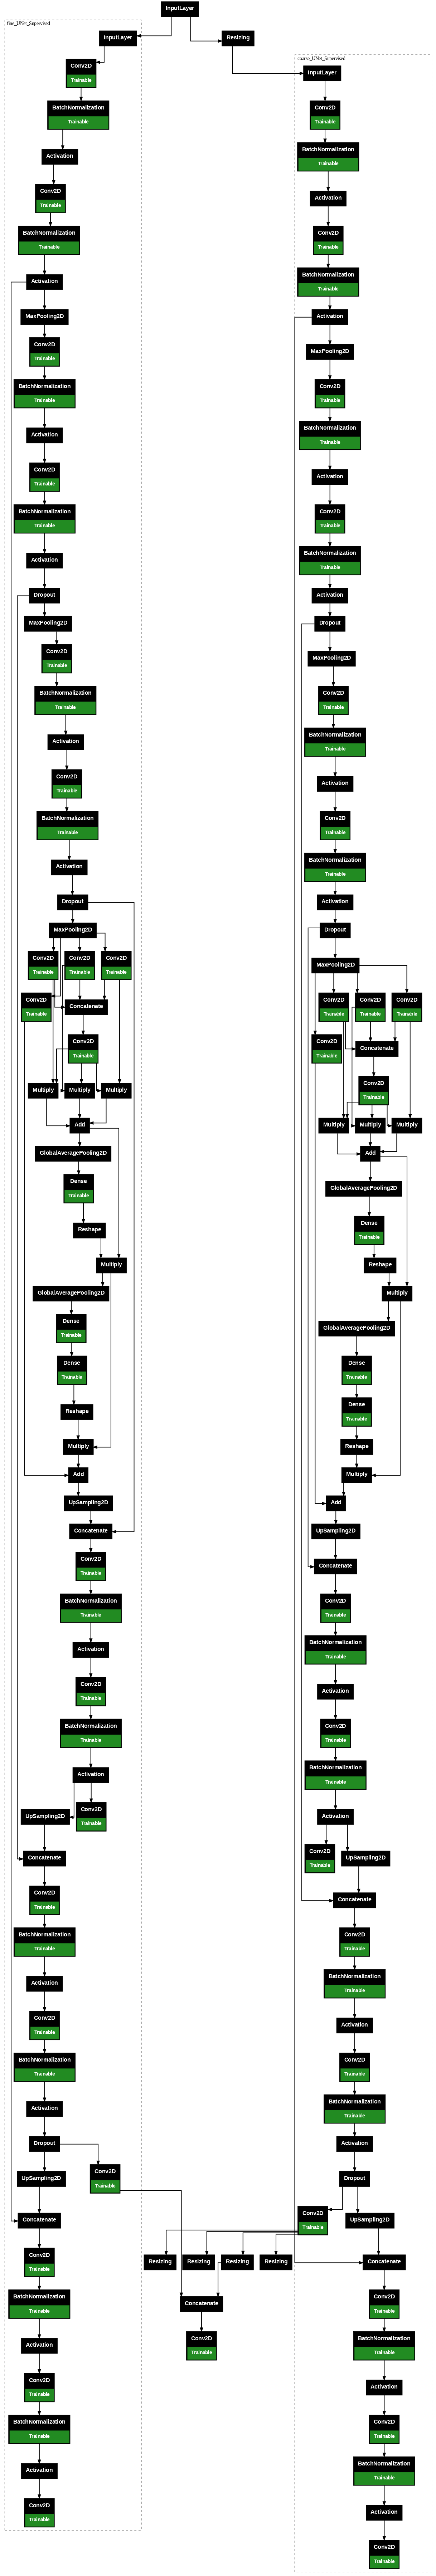

In [ ]:
model = get_dual_unet_model_with_supervision()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

### Loss definitions

In [ ]:
# Load the NumPy array which extracts labels from the train_dataset
all_labels = np.load('../Dataset/all_labels.npy')

In [ ]:
def modify_class_weights(all_labels, background_class=0, reduction_factor=0.85):
    """
    Modify class weights to reduce the importance of the background class.

    Parameters:
    all_labels (numpy.ndarray): Array of all labels
    background_class (int): Index of the background class
    reduction_factor (float): Factor to reduce background class weight
                               (0.85 means reducing to 85% of original weight)

    Returns:
    numpy.ndarray: Modified class weights
    """
    # Compute original balanced class weights
    classes = np.unique(all_labels)
    original_class_weights = compute_class_weight('balanced', classes=classes, y=all_labels)
    print("Original Class Weights:")
    for cls, weight in zip(classes, original_class_weights):
        print(f"Class {cls}: {weight:.4f}")

    # Find the index of the background class in the classes array
    background_index = np.where(classes == background_class)[0]

    if len(background_index) > 0:
        # Reduce the weight of the background class
        original_class_weights[background_index[0]] *= reduction_factor

    # Print out the modified weights for transparency
    print("Modified Class Weights:")
    for cls, weight in zip(classes, original_class_weights):
        print(f"Class {cls}: {weight:.4f}")

    return original_class_weights

# Get unique classes and compute modified class weights
classes = np.unique(all_labels)
class_weights = modify_class_weights(all_labels, background_class=0, reduction_factor=0)

# Convert class weights to TensorFlow-friendly format
alpha = tf.constant(class_weights, dtype=tf.float32)

Original Class Weights:
Class 0: 0.8212
Class 1: 0.5768
Class 2: 0.8581
Class 3: 1.1407
Class 4: 153.3580
Modified Class Weights:
Class 0: 0.0000
Class 1: 0.5768
Class 2: 0.8581
Class 3: 1.1407
Class 4: 153.3580


In [ ]:
# Function to compute boundary maps
def compute_boundary_map(y, num_classes):
    y_one_hot = tf.one_hot(tf.cast(y[..., 0], tf.int32), depth=num_classes)
    y_boundary = tf.image.sobel_edges(y_one_hot)  # Sobel edge detection
    y_boundary = tf.reduce_max(tf.abs(y_boundary), axis=-1)  # Combine x and y gradients
    return y_boundary

def boundary_loss(y_true, y_pred):
    num_classes = y_pred.shape[-1]

    # Compute boundary maps
    y_true_boundary = compute_boundary_map(y_true, num_classes)
    y_pred_boundary = compute_boundary_map(tf.argmax(y_pred, axis=-1)[..., tf.newaxis], num_classes)

    # L2 loss between boundary maps
    return tf.reduce_mean(tf.square(y_true_boundary - y_pred_boundary))

focal_loss = tf.keras.losses.CategoricalFocalCrossentropy(
    alpha=alpha,
    gamma=2.0,
    from_logits=False,
    reduction='sum_over_batch_size',
    name='categorical_focal_crossentropy'
)

dice_loss = tf.keras.losses.Dice(
    reduction='sum_over_batch_size',
    name='dice'
)

cross_entropy_loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction='sum_over_batch_size',
    name='sparse_categorical_crossentropy'
)

# Combined Loss Function
def combined_loss(y_true, y_pred):
    # Convert y_true to one-hot format for focal loss
    num_classes = y_pred.shape[-1]  # Extract number of classes
    y_true_one_hot = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=num_classes)  # One-hot encoding

    # Sparse Categorical Crossentropy
    ce = cross_entropy_loss(y_true, y_pred)

    # Dice Loss
    dice = dice_loss(y_true, y_pred)

    # Focal Loss
    focal = focal_loss(y_true_one_hot, y_pred)

    # Boundary Loss
    b_loss = boundary_loss(y_true, y_pred)

    # Weighted Combination
    return 0.1 * ce + 0.1 * dice + 0.8 * focal

# Combined Loss Function for coarse
def combined_loss_for_coarse(y_true, y_pred):
    # Convert y_true to one-hot format for focal loss
    num_classes = y_pred.shape[-1]  # Extract number of classes
    y_true_one_hot = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=num_classes)  # One-hot encoding

    # Sparse Categorical Crossentropy
    ce = cross_entropy_loss(y_true, y_pred)

    # Dice Loss
    dice = dice_loss(y_true, y_pred)

    # Focal Loss
    focal = focal_loss(y_true_one_hot, y_pred)

    # Boundary Loss
    b_loss = boundary_loss(y_true, y_pred)

    # Weighted Combination
    return 0.1 * ce + 0.1 * dice + 0.8 * focal

# Combined Loss Function for fine
def combined_loss_for_fine(y_true, y_pred):
    # Convert y_true to one-hot format for focal loss
    num_classes = y_pred.shape[-1]  # Extract number of classes
    y_true_one_hot = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=num_classes)  # One-hot encoding

    # Sparse Categorical Crossentropy
    ce = cross_entropy_loss(y_true, y_pred)

    # Dice Loss
    dice = dice_loss(y_true, y_pred)

    # Focal Loss
    focal = focal_loss(y_true_one_hot, y_pred)

    # Boundary Loss
    b_loss = boundary_loss(y_true, y_pred)

    # Weighted Combination
    return 0.1 * ce + 0.1 * dice + 0.8 * focal

### Compile and train the model

In [ ]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the stated[]
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)

            pred=pred[0]


            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = 5
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
print("Compiling model ...")
model.compile(
    #loss=combined_loss_with_dual_supervision,
    loss=[combined_loss, # main
          combined_loss_for_coarse,combined_loss_for_coarse,combined_loss_for_coarse, # coarse
          combined_loss_for_fine,combined_loss_for_fine,combined_loss_for_fine], # fine
    loss_weights = [0.5,0.1,0.1,0.1,0.15,0.15,0.15],
    optimizer=tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE),
    metrics=[
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for the main output
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for coarse output 1
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for coarse output 2
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for coarse output 3
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for fine output 1
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for fine output 2
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]  # Metrics for fine output 3
    ]
)
print("Model compiled!")

Compiling model ...
Model compiled!


In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_final_output_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(val_img[0], val_lbl[0])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=5e-5, verbose=1)

Epoch 1/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - final_output_accuracy: 0.2629 - final_output_mean_iou: 0.1221 - loss: 0.3255 

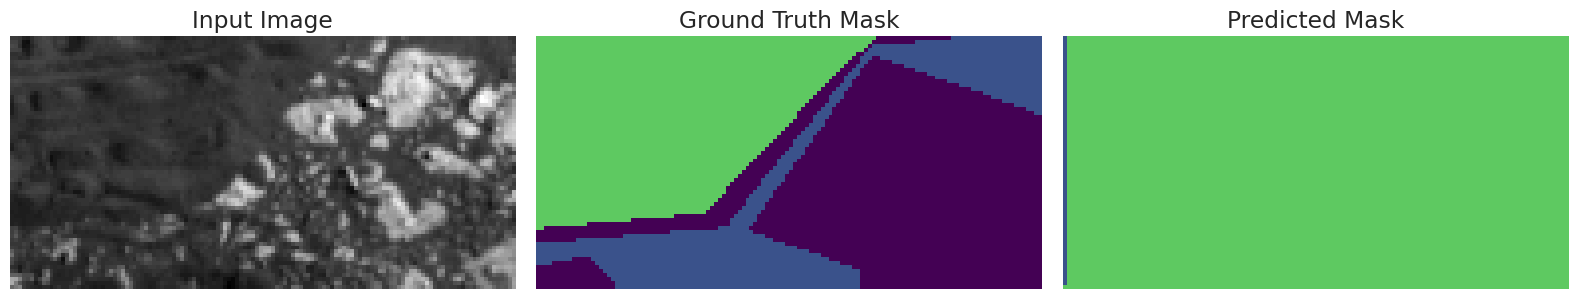

32/32 ━━━━━━━━━━━━━━━━━━━━ 1355s 41s/step - final_output_accuracy: 0.2640 - final_output_mean_iou: 0.1232 - loss: 0.3255 - val_final_output_accuracy: 0.2157 - val_final_output_mean_iou: 0.0720 - val_loss: 0.4855 - learning_rate: 0.0010
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 432ms/step - final_output_accuracy: 0.3202 - final_output_mean_iou: 0.2333 - loss: 0.2571 - val_final_output_accuracy: 0.2157 - val_final_output_mean_iou: 0.0720 - val_loss: 0.5261 - learning_rate: 0.0010
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 445ms/step - final_output_accuracy: 0.3443 - final_output_mean_iou: 0.2484 - loss: 0.2381 - val_final_output_accuracy: 0.2154 - val_final_output_mean_iou: 0.0709 - val_loss: 0.5895 - learning_rate: 0.0010
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 448ms/step - final_output_accuracy: 0.3761 - final_output_mean_iou: 0.2760 - loss: 0.2350 - val_final_output_accuracy: 0.2154 - val_final_output_mean_iou: 0.0709 - val_loss: 0.6473 - learning_rate: 0.0010
Epoch 5/1000
32/3

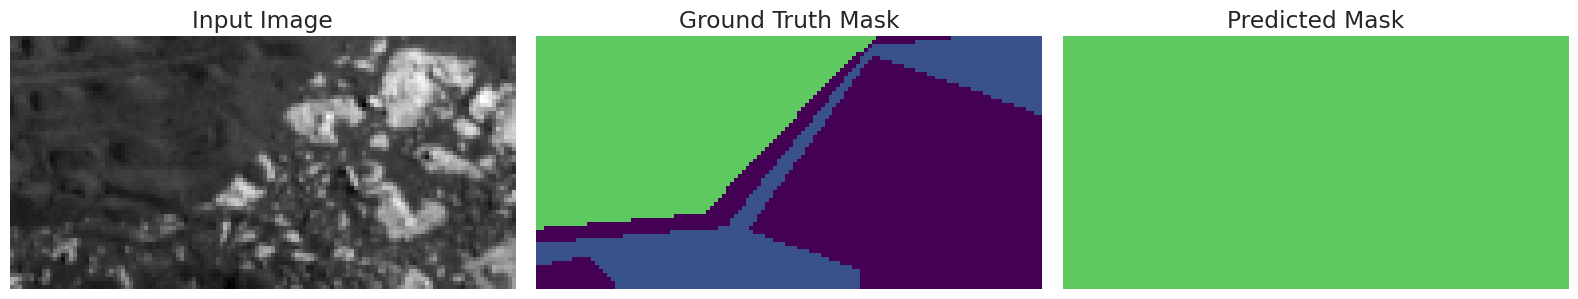

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 475ms/step - final_output_accuracy: 0.4543 - final_output_mean_iou: 0.3484 - loss: 0.1990 - val_final_output_accuracy: 0.2154 - val_final_output_mean_iou: 0.0709 - val_loss: 0.6859 - learning_rate: 0.0010
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 415ms/step - final_output_accuracy: 0.4321 - final_output_mean_iou: 0.3228 - loss: 0.2038 - val_final_output_accuracy: 0.2154 - val_final_output_mean_iou: 0.0709 - val_loss: 0.7163 - learning_rate: 0.0010
Epoch 8/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 384ms/step - final_output_accuracy: 0.4404 - final_output_mean_iou: 0.3299 - loss: 0.1903 - val_final_output_accuracy: 0.2154 - val_final_output_mean_iou: 0.0709 - val_loss: 0.7384 - learning_rate: 0.0010
Epoch 9/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 442ms/step - final_output_accuracy: 0.4662 - final_output_mean_iou: 0.3635 - loss: 0.1854 - val_final_output_accuracy: 0.2154 - val_final_output_mean_iou: 0.0709 - val_loss: 0.7225 - learning_rate: 0.0010
Epoch 10/1000
32/

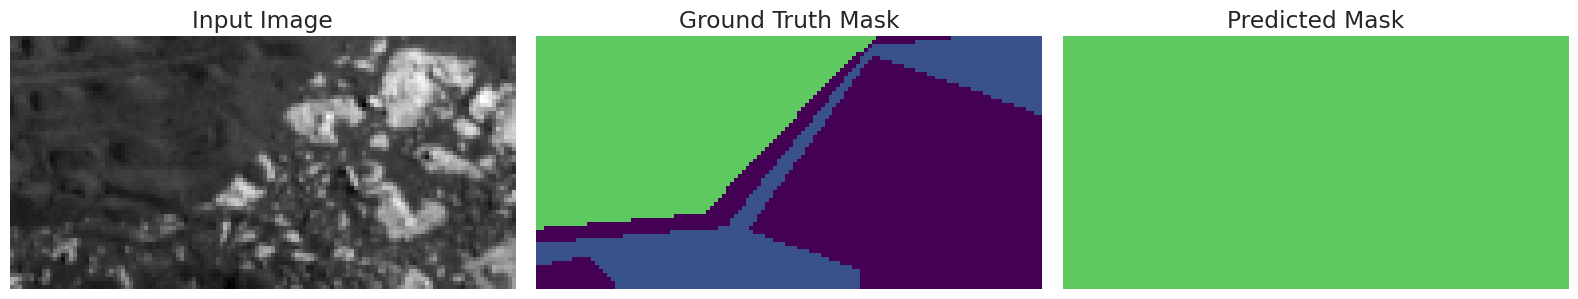

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 465ms/step - final_output_accuracy: 0.4367 - final_output_mean_iou: 0.3434 - loss: 0.1881 - val_final_output_accuracy: 0.2154 - val_final_output_mean_iou: 0.0709 - val_loss: 0.7873 - learning_rate: 0.0010
Epoch 12/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 412ms/step - final_output_accuracy: 0.4289 - final_output_mean_iou: 0.3248 - loss: 0.1918 - val_final_output_accuracy: 0.2154 - val_final_output_mean_iou: 0.0709 - val_loss: 0.8052 - learning_rate: 0.0010
Epoch 13/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - final_output_accuracy: 0.4840 - final_output_mean_iou: 0.3858 - loss: 0.1745 - val_final_output_accuracy: 0.2154 - val_final_output_mean_iou: 0.0709 - val_loss: 0.8389 - learning_rate: 0.0010
Epoch 14/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 427ms/step - final_output_accuracy: 0.4468 - final_output_mean_iou: 0.3526 - loss: 0.1882 - val_final_output_accuracy: 0.2157 - val_final_output_mean_iou: 0.0713 - val_loss: 0.8394 - learning_rate: 0.0010
Epoch 15/1000


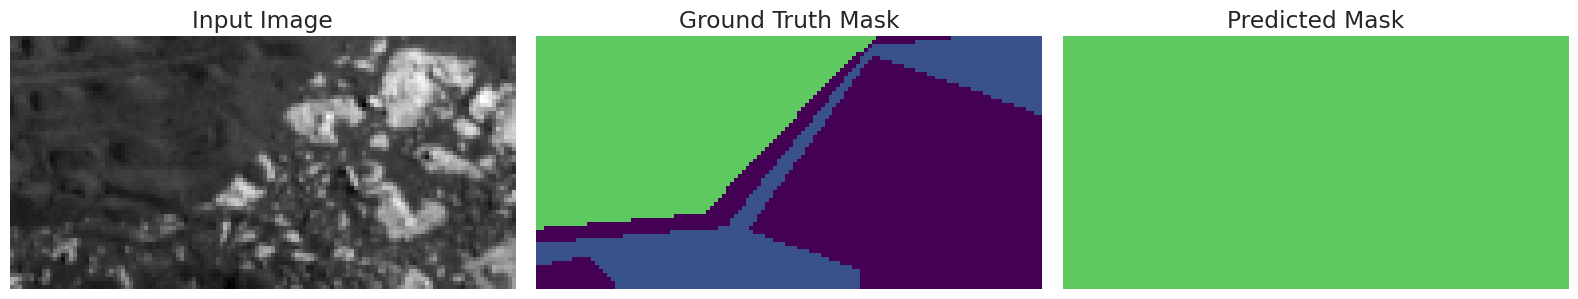


Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 445ms/step - final_output_accuracy: 0.4861 - final_output_mean_iou: 0.3942 - loss: 0.1665 - val_final_output_accuracy: 0.2691 - val_final_output_mean_iou: 0.1221 - val_loss: 0.6853 - learning_rate: 0.0010
Epoch 17/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 413ms/step - final_output_accuracy: 0.5039 - final_output_mean_iou: 0.4043 - loss: 0.1634 - val_final_output_accuracy: 0.3333 - val_final_output_mean_iou: 0.1821 - val_loss: 0.5558 - learning_rate: 5.0000e-04
Epoch 18/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 407ms/step - final_output_accuracy: 0.5278 - final_output_mean_iou: 0.4368 - loss: 0.1474 - val_final_output_accuracy: 0.3954 - val_final_output_mean_iou: 0.2609 - val_loss: 0.4448 - learning_rate: 5.0000e-04
Epoch 19/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 438ms/step - final_output_accuracy: 0.5351 - final_output_mean_iou: 0.4442 - loss: 0.1556 - val_final_output_accuracy: 0.3973 - val_f

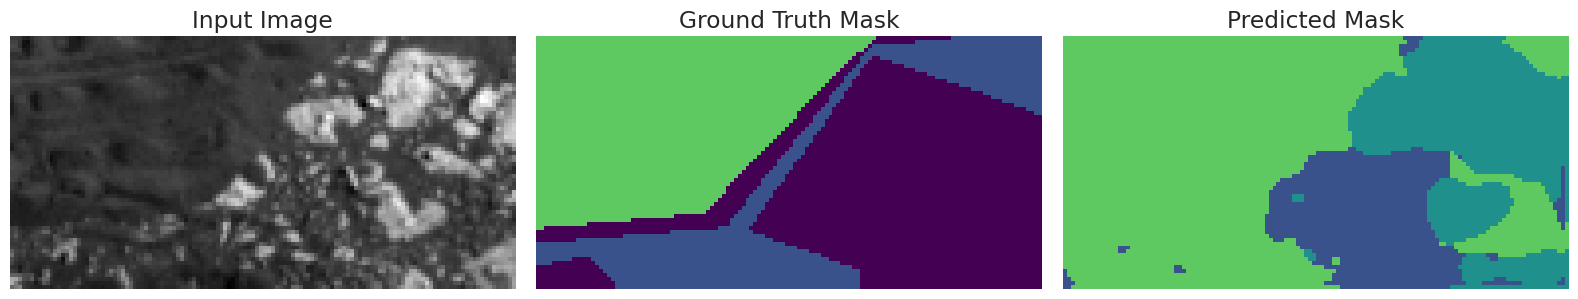

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 432ms/step - final_output_accuracy: 0.5536 - final_output_mean_iou: 0.4628 - loss: 0.1390 - val_final_output_accuracy: 0.4796 - val_final_output_mean_iou: 0.3840 - val_loss: 0.2708 - learning_rate: 5.0000e-04
Epoch 22/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 450ms/step - final_output_accuracy: 0.5473 - final_output_mean_iou: 0.4608 - loss: 0.1472 - val_final_output_accuracy: 0.4584 - val_final_output_mean_iou: 0.3538 - val_loss: 0.1989 - learning_rate: 5.0000e-04
Epoch 23/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 413ms/step - final_output_accuracy: 0.5503 - final_output_mean_iou: 0.4675 - loss: 0.1438 - val_final_output_accuracy: 0.4262 - val_final_output_mean_iou: 0.3123 - val_loss: 0.2047 - learning_rate: 5.0000e-04
Epoch 24/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 437ms/step - final_output_accuracy: 0.5637 - final_output_mean_iou: 0.4793 - loss: 0.1383 - val_final_output_accuracy: 0.5325 - val_final_output_mean_iou: 0.4321 - val_loss: 0.1948 - learning_rate: 5.0000e-0

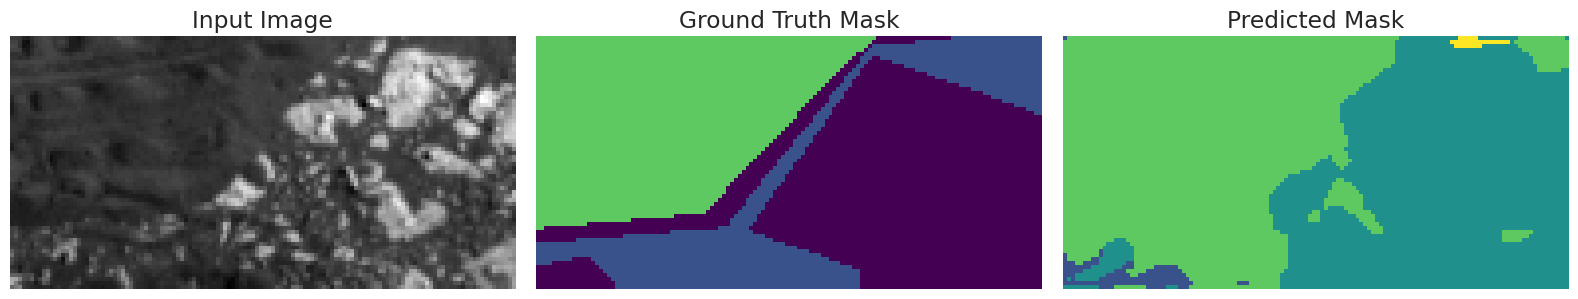

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 429ms/step - final_output_accuracy: 0.5802 - final_output_mean_iou: 0.4960 - loss: 0.1282 - val_final_output_accuracy: 0.4766 - val_final_output_mean_iou: 0.3743 - val_loss: 0.1968 - learning_rate: 5.0000e-04
Epoch 27/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 446ms/step - final_output_accuracy: 0.5780 - final_output_mean_iou: 0.4960 - loss: 0.1294 - val_final_output_accuracy: 0.4670 - val_final_output_mean_iou: 0.3723 - val_loss: 0.1990 - learning_rate: 5.0000e-04
Epoch 28/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 407ms/step - final_output_accuracy: 0.5165 - final_output_mean_iou: 0.4216 - loss: 0.1540 - val_final_output_accuracy: 0.4365 - val_final_output_mean_iou: 0.3323 - val_loss: 0.1981 - learning_rate: 5.0000e-04
Epoch 29/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 398ms/step - final_output_accuracy: 0.5468 - final_output_mean_iou: 0.4579 - loss: 0.1400 - val_final_output_accuracy: 0.5329 - val_final_output_mean_iou: 0.4495 - val_loss: 0.1613 - learning_rate: 5.0000e-0

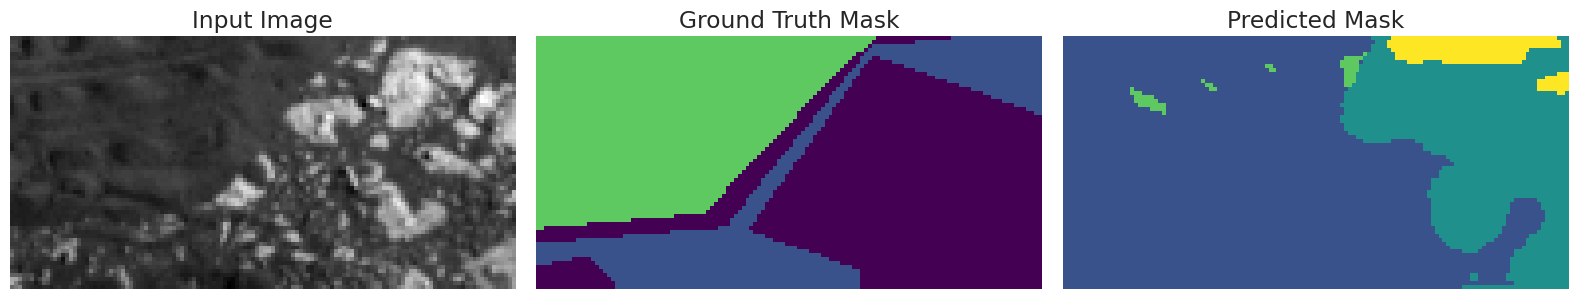

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 420ms/step - final_output_accuracy: 0.5549 - final_output_mean_iou: 0.4695 - loss: 0.1420 - val_final_output_accuracy: 0.4494 - val_final_output_mean_iou: 0.3277 - val_loss: 0.3559 - learning_rate: 5.0000e-04
Epoch 32/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 445ms/step - final_output_accuracy: 0.5329 - final_output_mean_iou: 0.4375 - loss: 0.1497 - val_final_output_accuracy: 0.5811 - val_final_output_mean_iou: 0.4963 - val_loss: 0.1841 - learning_rate: 5.0000e-04
Epoch 33/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 448ms/step - final_output_accuracy: 0.5678 - final_output_mean_iou: 0.4801 - loss: 0.1339 - val_final_output_accuracy: 0.5795 - val_final_output_mean_iou: 0.4930 - val_loss: 0.1833 - learning_rate: 5.0000e-04
Epoch 34/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 393ms/step - final_output_accuracy: 0.5286 - final_output_mean_iou: 0.4377 - loss: 0.1630 - val_final_output_accuracy: 0.3968 - val_final_output_mean_iou: 0.2906 - val_loss: 0.2622 - learning_rate: 5.0000e-0

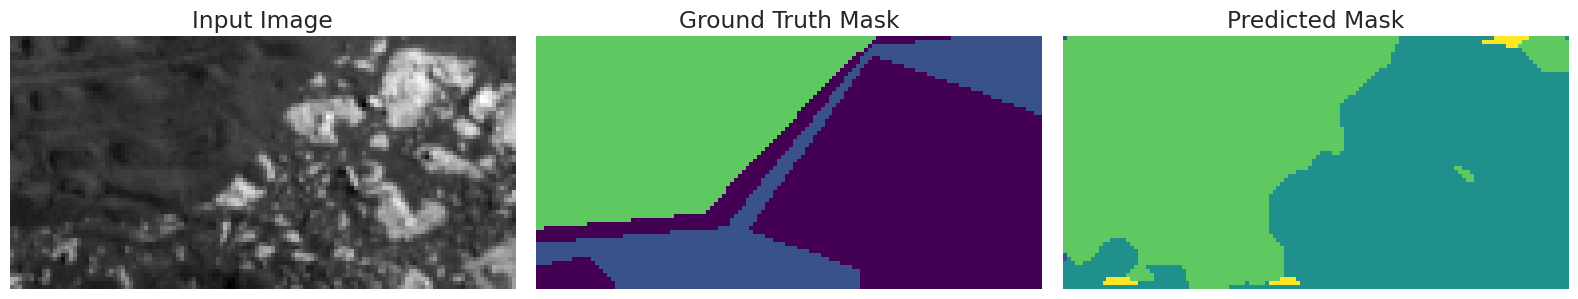

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 470ms/step - final_output_accuracy: 0.5646 - final_output_mean_iou: 0.4869 - loss: 0.1336 - val_final_output_accuracy: 0.4240 - val_final_output_mean_iou: 0.3280 - val_loss: 0.2147 - learning_rate: 5.0000e-04
Epoch 37/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 443ms/step - final_output_accuracy: 0.5719 - final_output_mean_iou: 0.4906 - loss: 0.1296 - val_final_output_accuracy: 0.2370 - val_final_output_mean_iou: 0.2206 - val_loss: 0.2975 - learning_rate: 5.0000e-04
Epoch 38/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 442ms/step - final_output_accuracy: 0.5532 - final_output_mean_iou: 0.4674 - loss: 0.1375 - val_final_output_accuracy: 0.2254 - val_final_output_mean_iou: 0.2114 - val_loss: 0.2967 - learning_rate: 5.0000e-04
Epoch 39/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 442ms/step - final_output_accuracy: 0.5576 - final_output_mean_iou: 0.4689 - loss: 0.1343 - val_final_output_accuracy: 0.3509 - val_final_output_mean_iou: 0.2727 - val_loss: 0.2368 - learning_rate: 5.0000e-0

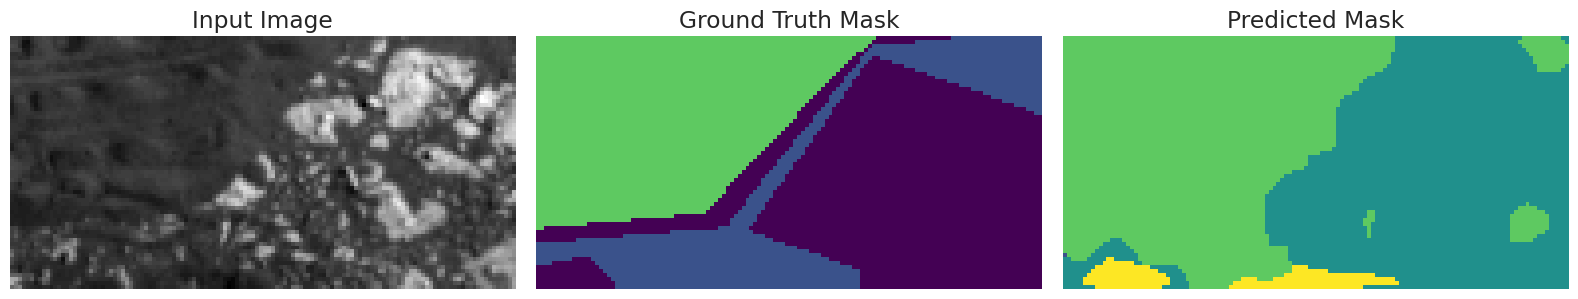

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - final_output_accuracy: 0.5934 - final_output_mean_iou: 0.5108 - loss: 0.1234 - val_final_output_accuracy: 0.3986 - val_final_output_mean_iou: 0.2978 - val_loss: 0.2225 - learning_rate: 5.0000e-04
Epoch 42/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 439ms/step - final_output_accuracy: 0.6049 - final_output_mean_iou: 0.5262 - loss: 0.1186 - val_final_output_accuracy: 0.5104 - val_final_output_mean_iou: 0.4288 - val_loss: 0.1663 - learning_rate: 5.0000e-04
Epoch 43/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 410ms/step - final_output_accuracy: 0.5907 - final_output_mean_iou: 0.5081 - loss: 0.1201 - val_final_output_accuracy: 0.5827 - val_final_output_mean_iou: 0.5052 - val_loss: 0.1643 - learning_rate: 5.0000e-04
Epoch 44/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 439ms/step - final_output_accuracy: 0.5884 - final_output_mean_iou: 0.5099 - loss: 0.1201 - val_final_output_accuracy: 0.5771 - val_final_output_mean_iou: 0.4895 - val_loss: 0.1688 - learning_rate: 5.0000e-0

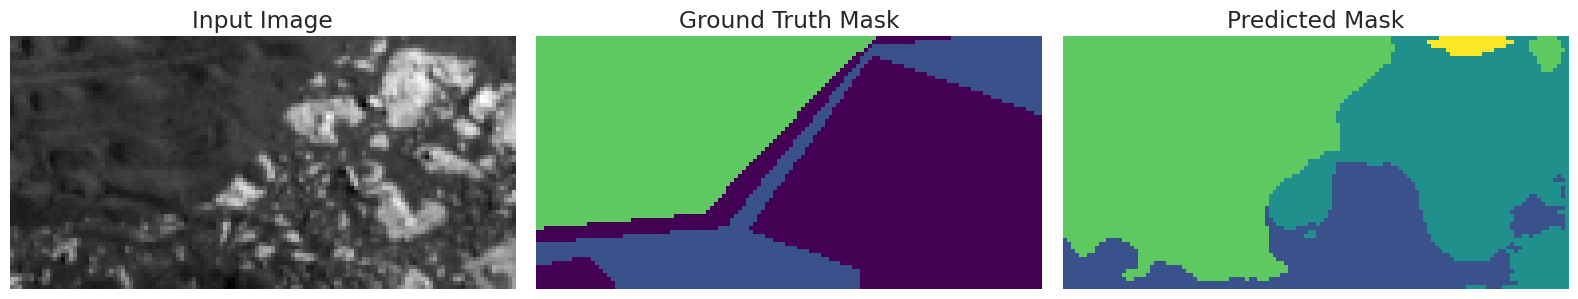

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 423ms/step - final_output_accuracy: 0.6064 - final_output_mean_iou: 0.5251 - loss: 0.1140 - val_final_output_accuracy: 0.6299 - val_final_output_mean_iou: 0.5658 - val_loss: 0.1656 - learning_rate: 2.5000e-04
Epoch 47/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 429ms/step - final_output_accuracy: 0.6090 - final_output_mean_iou: 0.5374 - loss: 0.1095 - val_final_output_accuracy: 0.6322 - val_final_output_mean_iou: 0.5704 - val_loss: 0.1797 - learning_rate: 2.5000e-04
Epoch 48/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step - final_output_accuracy: 0.6061 - final_output_mean_iou: 0.5349 - loss: 0.1107 - val_final_output_accuracy: 0.6213 - val_final_output_mean_iou: 0.5536 - val_loss: 0.1619 - learning_rate: 2.5000e-04
Epoch 49/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 418ms/step - final_output_accuracy: 0.6047 - final_output_mean_iou: 0.5274 - loss: 0.1196 - val_final_output_accuracy: 0.6238 - val_final_output_mean_iou: 0.5580 - val_loss: 0.1718 - learning_rate: 2.5000e-0

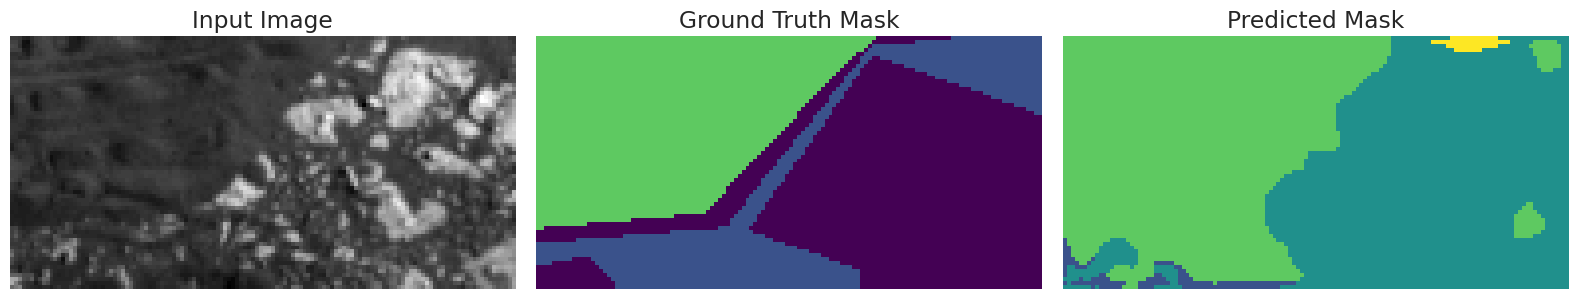

32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 461ms/step - final_output_accuracy: 0.6035 - final_output_mean_iou: 0.5267 - loss: 0.1152 - val_final_output_accuracy: 0.6229 - val_final_output_mean_iou: 0.5590 - val_loss: 0.1682 - learning_rate: 2.5000e-04
Epoch 52/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 449ms/step - final_output_accuracy: 0.6175 - final_output_mean_iou: 0.5431 - loss: 0.1088 - val_final_output_accuracy: 0.6326 - val_final_output_mean_iou: 0.5751 - val_loss: 0.1678 - learning_rate: 2.5000e-04
Epoch 53/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 420ms/step - final_output_accuracy: 0.6164 - final_output_mean_iou: 0.5367 - loss: 0.1154 - val_final_output_accuracy: 0.5172 - val_final_output_mean_iou: 0.4364 - val_loss: 0.1858 - learning_rate: 2.5000e-04
Epoch 54/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 430ms/step - final_output_accuracy: 0.6131 - final_output_mean_iou: 0.5391 - loss: 0.1087 - val_final_output_accuracy: 0.5897 - val_final_output_mean_iou: 0.5212 - val_loss: 0.1813 - learning_rate: 2.5000e-0

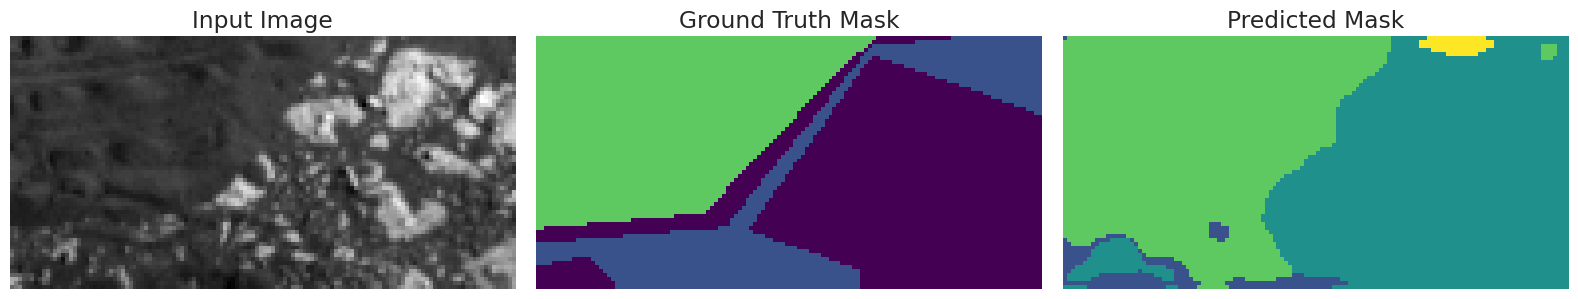

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 430ms/step - final_output_accuracy: 0.6200 - final_output_mean_iou: 0.5483 - loss: 0.1035 - val_final_output_accuracy: 0.5932 - val_final_output_mean_iou: 0.5147 - val_loss: 0.1734 - learning_rate: 2.5000e-04
Epoch 57/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 409ms/step - final_output_accuracy: 0.6193 - final_output_mean_iou: 0.5427 - loss: 0.1073 - val_final_output_accuracy: 0.5591 - val_final_output_mean_iou: 0.4817 - val_loss: 0.1868 - learning_rate: 2.5000e-04
Epoch 58/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 408ms/step - final_output_accuracy: 0.6276 - final_output_mean_iou: 0.5574 - loss: 0.1040 - val_final_output_accuracy: 0.5831 - val_final_output_mean_iou: 0.5243 - val_loss: 0.1794 - learning_rate: 2.5000e-04
Epoch 59/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 432ms/step - final_output_accuracy: 0.6309 - final_output_mean_iou: 0.5564 - loss: 0.1020 - val_final_output_accuracy: 0.6148 - val_final_output_mean_iou: 0.5500 - val_loss: 0.1666 - learning_rate: 2.5000e-0

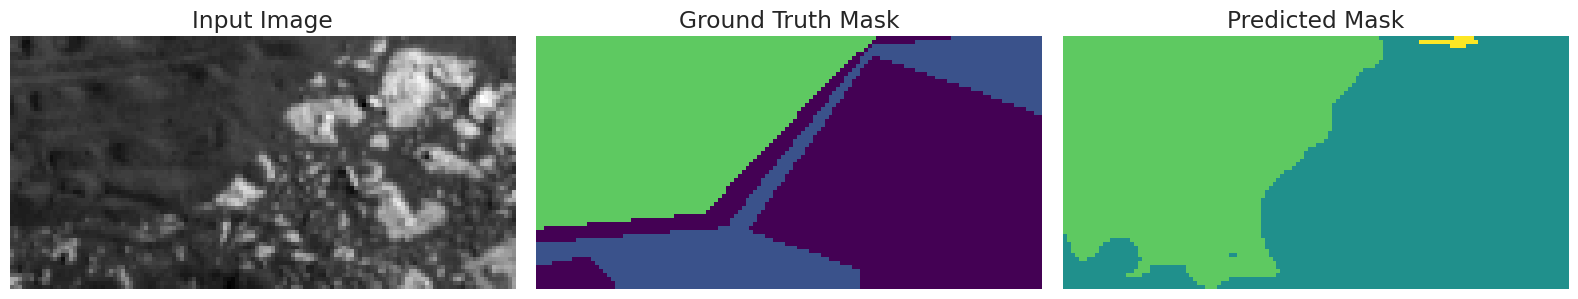

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - final_output_accuracy: 0.6283 - final_output_mean_iou: 0.5552 - loss: 0.1023 - val_final_output_accuracy: 0.6195 - val_final_output_mean_iou: 0.5550 - val_loss: 0.1665 - learning_rate: 1.2500e-04
Epoch 62/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 424ms/step - final_output_accuracy: 0.6410 - final_output_mean_iou: 0.5710 - loss: 0.0971 - val_final_output_accuracy: 0.6201 - val_final_output_mean_iou: 0.5611 - val_loss: 0.1667 - learning_rate: 1.2500e-04
Epoch 63/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 421ms/step - final_output_accuracy: 0.6416 - final_output_mean_iou: 0.5715 - loss: 0.0964 - val_final_output_accuracy: 0.6340 - val_final_output_mean_iou: 0.5837 - val_loss: 0.1817 - learning_rate: 1.2500e-04
Epoch 64/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 421ms/step - final_output_accuracy: 0.6228 - final_output_mean_iou: 0.5480 - loss: 0.1018 - val_final_output_accuracy: 0.6345 - val_final_output_mean_iou: 0.5824 - val_loss: 0.1790 - learning_rate: 1.2500e-0

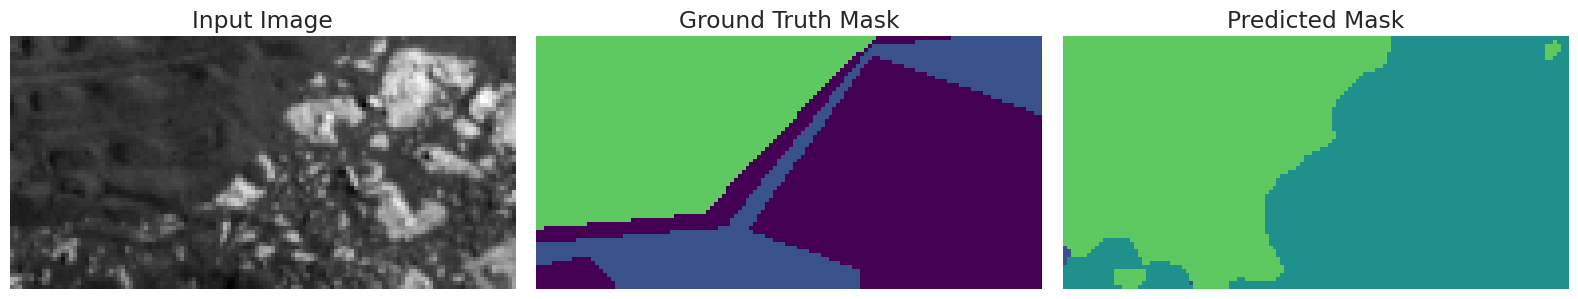

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 438ms/step - final_output_accuracy: 0.6405 - final_output_mean_iou: 0.5817 - loss: 0.0921 - val_final_output_accuracy: 0.6389 - val_final_output_mean_iou: 0.6024 - val_loss: 0.1809 - learning_rate: 1.2500e-04
Epoch 67/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 396ms/step - final_output_accuracy: 0.6445 - final_output_mean_iou: 0.5810 - loss: 0.0947 - val_final_output_accuracy: 0.6322 - val_final_output_mean_iou: 0.5843 - val_loss: 0.1688 - learning_rate: 1.2500e-04
Epoch 68/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 419ms/step - final_output_accuracy: 0.6425 - final_output_mean_iou: 0.5802 - loss: 0.0942 - val_final_output_accuracy: 0.5929 - val_final_output_mean_iou: 0.5175 - val_loss: 0.1753 - learning_rate: 1.2500e-04
Epoch 69/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - final_output_accuracy: 0.6397 - final_output_mean_iou: 0.5754 - loss: 0.0952 - val_final_output_accuracy: 0.6230 - val_final_output_mean_iou: 0.5615 - val_loss: 0.1668 - learning_rate: 1.2500e-0

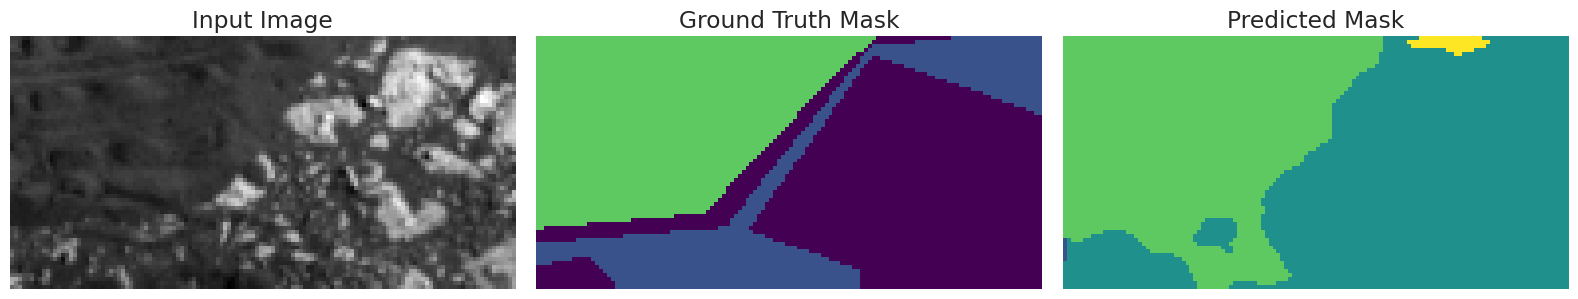

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 424ms/step - final_output_accuracy: 0.6413 - final_output_mean_iou: 0.5778 - loss: 0.0912 - val_final_output_accuracy: 0.6203 - val_final_output_mean_iou: 0.5595 - val_loss: 0.1684 - learning_rate: 1.2500e-04
Epoch 72/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 422ms/step - final_output_accuracy: 0.6347 - final_output_mean_iou: 0.5657 - loss: 0.0972 - val_final_output_accuracy: 0.6312 - val_final_output_mean_iou: 0.5748 - val_loss: 0.1686 - learning_rate: 1.2500e-04
Epoch 73/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 420ms/step - final_output_accuracy: 0.6464 - final_output_mean_iou: 0.5794 - loss: 0.0914 - val_final_output_accuracy: 0.6332 - val_final_output_mean_iou: 0.5804 - val_loss: 0.1717 - learning_rate: 1.2500e-04
Epoch 74/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 420ms/step - final_output_accuracy: 0.6496 - final_output_mean_iou: 0.5863 - loss: 0.0895 - val_final_output_accuracy: 0.6221 - val_final_output_mean_iou: 0.5662 - val_loss: 0.1755 - learning_rate: 1.2500e-0

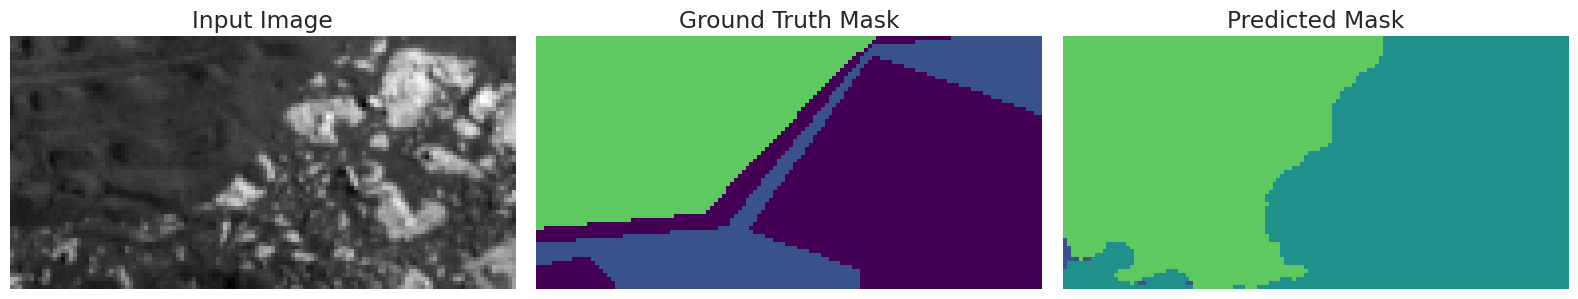

32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 467ms/step - final_output_accuracy: 0.6452 - final_output_mean_iou: 0.5822 - loss: 0.0906 - val_final_output_accuracy: 0.6526 - val_final_output_mean_iou: 0.6108 - val_loss: 0.1660 - learning_rate: 6.2500e-05
Epoch 77/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 419ms/step - final_output_accuracy: 0.6493 - final_output_mean_iou: 0.5878 - loss: 0.0886 - val_final_output_accuracy: 0.6497 - val_final_output_mean_iou: 0.6050 - val_loss: 0.1680 - learning_rate: 6.2500e-05
Epoch 78/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 420ms/step - final_output_accuracy: 0.6500 - final_output_mean_iou: 0.5915 - loss: 0.0882 - val_final_output_accuracy: 0.6463 - val_final_output_mean_iou: 0.6004 - val_loss: 0.1690 - learning_rate: 6.2500e-05
Epoch 79/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 427ms/step - final_output_accuracy: 0.6496 - final_output_mean_iou: 0.5871 - loss: 0.0888 - val_final_output_accuracy: 0.6551 - val_final_output_mean_iou: 0.6172 - val_loss: 0.1763 - learning_rate: 6.2500e-0

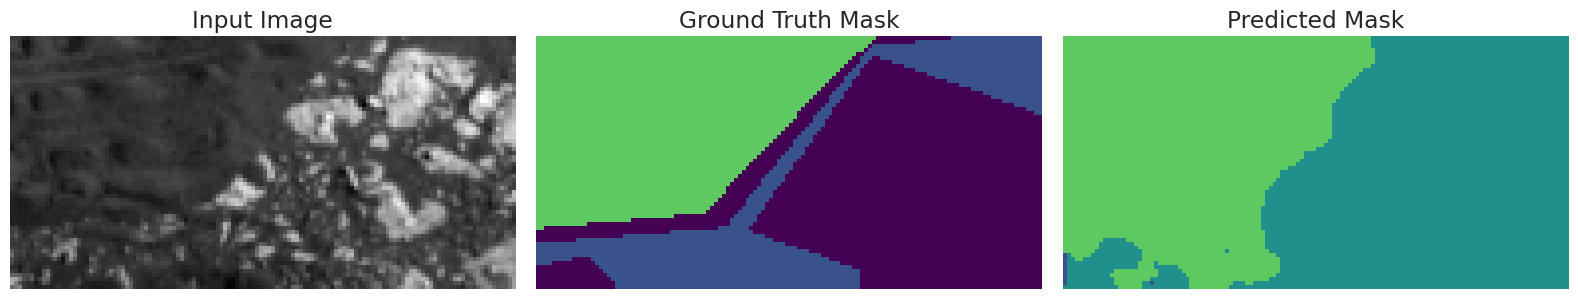

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 433ms/step - final_output_accuracy: 0.6509 - final_output_mean_iou: 0.5902 - loss: 0.0889 - val_final_output_accuracy: 0.6553 - val_final_output_mean_iou: 0.6211 - val_loss: 0.1755 - learning_rate: 6.2500e-05
Epoch 82/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 419ms/step - final_output_accuracy: 0.6468 - final_output_mean_iou: 0.5873 - loss: 0.0889 - val_final_output_accuracy: 0.6522 - val_final_output_mean_iou: 0.6156 - val_loss: 0.1807 - learning_rate: 6.2500e-05
Epoch 83/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 397ms/step - final_output_accuracy: 0.6481 - final_output_mean_iou: 0.5862 - loss: 0.0886 - val_final_output_accuracy: 0.6283 - val_final_output_mean_iou: 0.5800 - val_loss: 0.1818 - learning_rate: 6.2500e-05
Epoch 84/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - final_output_accuracy: 0.6476 - final_output_mean_iou: 0.5875 - loss: 0.0879 - val_final_output_accuracy: 0.6258 - val_final_output_mean_iou: 0.5783 - val_loss: 0.1833 - learning_rate: 6.2500e-0

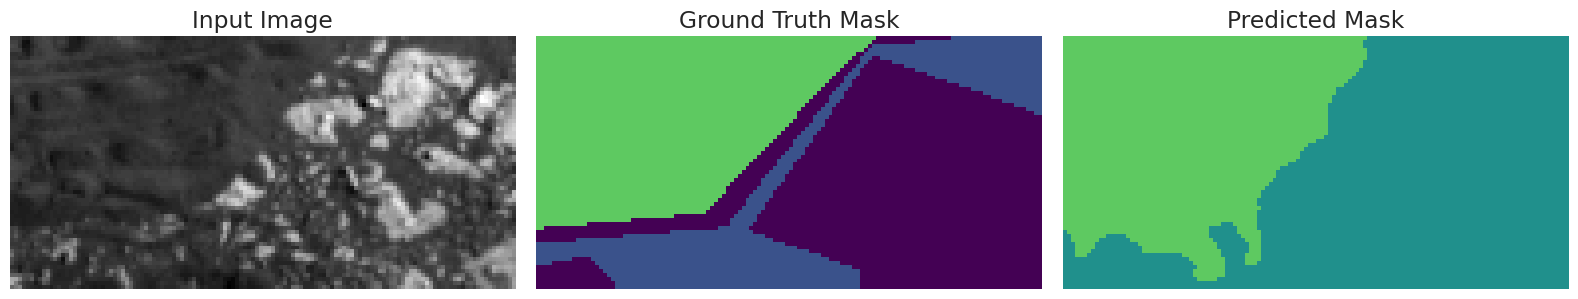

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 467ms/step - final_output_accuracy: 0.6502 - final_output_mean_iou: 0.5862 - loss: 0.0851 - val_final_output_accuracy: 0.6296 - val_final_output_mean_iou: 0.5825 - val_loss: 0.1882 - learning_rate: 6.2500e-05
Epoch 87/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 408ms/step - final_output_accuracy: 0.6524 - final_output_mean_iou: 0.5893 - loss: 0.0867 - val_final_output_accuracy: 0.6633 - val_final_output_mean_iou: 0.6241 - val_loss: 0.1854 - learning_rate: 6.2500e-05
Epoch 88/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 447ms/step - final_output_accuracy: 0.6587 - final_output_mean_iou: 0.6013 - loss: 0.0838 - val_final_output_accuracy: 0.6582 - val_final_output_mean_iou: 0.6206 - val_loss: 0.1876 - learning_rate: 6.2500e-05
Epoch 89/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 425ms/step - final_output_accuracy: 0.6551 - final_output_mean_iou: 0.5939 - loss: 0.0864 - val_final_output_accuracy: 0.6519 - val_final_output_mean_iou: 0.6153 - val_loss: 0.1848 - learning_rate: 6.2500e-0

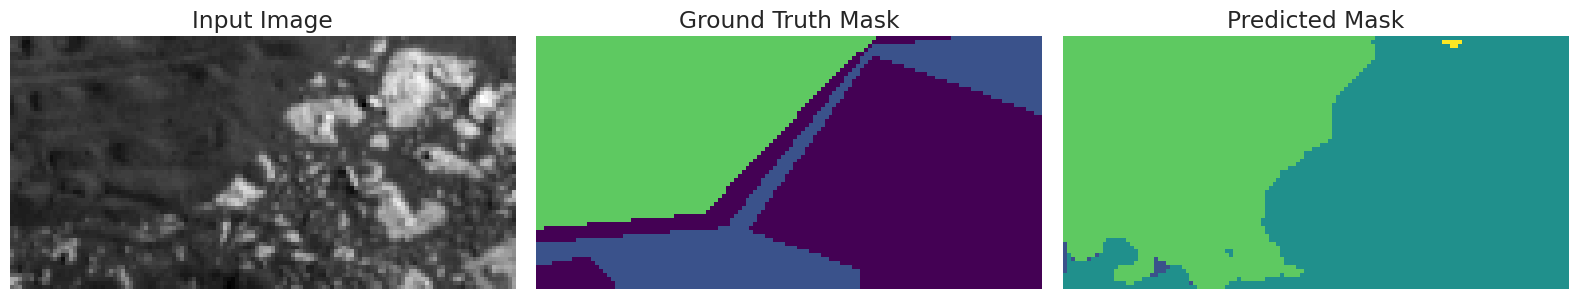

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 439ms/step - final_output_accuracy: 0.6637 - final_output_mean_iou: 0.6092 - loss: 0.0804 - val_final_output_accuracy: 0.6595 - val_final_output_mean_iou: 0.6315 - val_loss: 0.1724 - learning_rate: 5.0000e-05
Epoch 92/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 443ms/step - final_output_accuracy: 0.6647 - final_output_mean_iou: 0.6081 - loss: 0.0806 - val_final_output_accuracy: 0.6583 - val_final_output_mean_iou: 0.6300 - val_loss: 0.1705 - learning_rate: 5.0000e-05
Epoch 93/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 442ms/step - final_output_accuracy: 0.6601 - final_output_mean_iou: 0.6095 - loss: 0.0805 - val_final_output_accuracy: 0.6401 - val_final_output_mean_iou: 0.6049 - val_loss: 0.1742 - learning_rate: 5.0000e-05
Epoch 94/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - final_output_accuracy: 0.6546 - final_output_mean_iou: 0.5962 - loss: 0.0833 - val_final_output_accuracy: 0.6456 - val_final_output_mean_iou: 0.6103 - val_loss: 0.1760 - learning_rate: 5.0000e-0

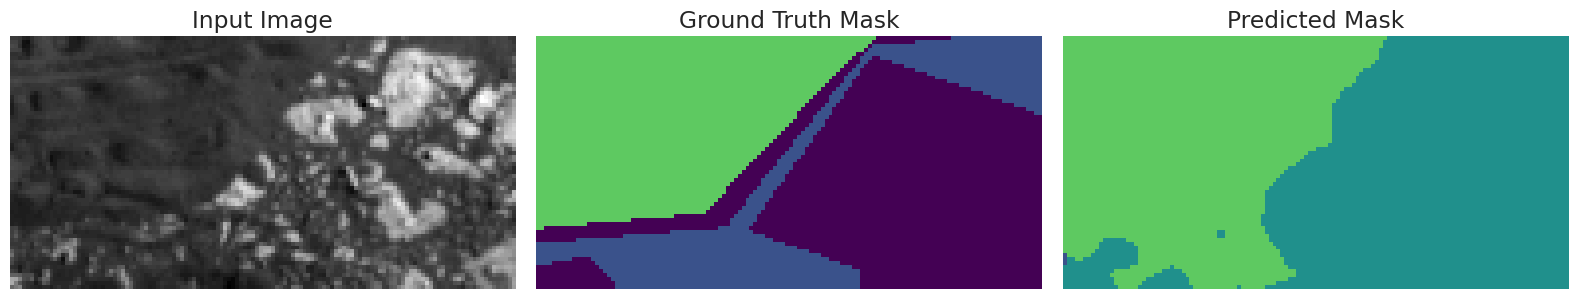

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step - final_output_accuracy: 0.6654 - final_output_mean_iou: 0.6108 - loss: 0.0792 - val_final_output_accuracy: 0.6559 - val_final_output_mean_iou: 0.6167 - val_loss: 0.1734 - learning_rate: 5.0000e-05
Epoch 97/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step - final_output_accuracy: 0.6446 - final_output_mean_iou: 0.5812 - loss: 0.0905 - val_final_output_accuracy: 0.6324 - val_final_output_mean_iou: 0.5736 - val_loss: 0.1771 - learning_rate: 5.0000e-05
Epoch 98/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - final_output_accuracy: 0.6605 - final_output_mean_iou: 0.6071 - loss: 0.0838 - val_final_output_accuracy: 0.6375 - val_final_output_mean_iou: 0.5869 - val_loss: 0.1701 - learning_rate: 5.0000e-05
Epoch 99/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 420ms/step - final_output_accuracy: 0.6591 - final_output_mean_iou: 0.6036 - loss: 0.0818 - val_final_output_accuracy: 0.6520 - val_final_output_mean_iou: 0.6088 - val_loss: 0.1680 - learning_rate: 5.0000e-0

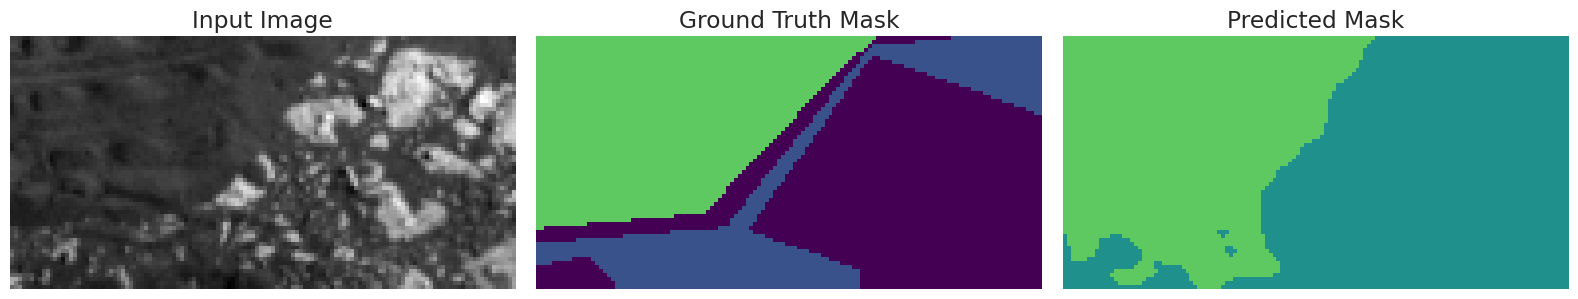

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 463ms/step - final_output_accuracy: 0.6574 - final_output_mean_iou: 0.6014 - loss: 0.0852 - val_final_output_accuracy: 0.6346 - val_final_output_mean_iou: 0.5882 - val_loss: 0.1673 - learning_rate: 5.0000e-05
Epoch 102/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 410ms/step - final_output_accuracy: 0.6534 - final_output_mean_iou: 0.5977 - loss: 0.0863 - val_final_output_accuracy: 0.6530 - val_final_output_mean_iou: 0.6153 - val_loss: 0.1666 - learning_rate: 5.0000e-05
Epoch 103/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 450ms/step - final_output_accuracy: 0.6617 - final_output_mean_iou: 0.6081 - loss: 0.0814 - val_final_output_accuracy: 0.6409 - val_final_output_mean_iou: 0.5988 - val_loss: 0.1746 - learning_rate: 5.0000e-05
Epoch 104/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - final_output_accuracy: 0.6657 - final_output_mean_iou: 0.6039 - loss: 0.0793 - val_final_output_accuracy: 0.6639 - val_final_output_mean_iou: 0.6318 - val_loss: 0.1662 - learning_rate: 5.0000

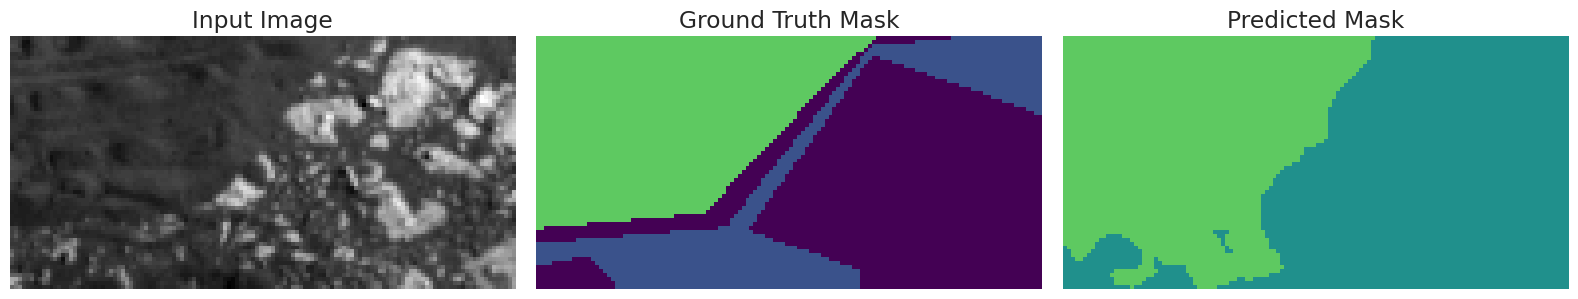

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 437ms/step - final_output_accuracy: 0.6621 - final_output_mean_iou: 0.4980 - loss: 0.0811 - val_final_output_accuracy: 0.6495 - val_final_output_mean_iou: 0.6177 - val_loss: 0.1815 - learning_rate: 5.0000e-05
Epoch 107/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - final_output_accuracy: 0.6617 - final_output_mean_iou: 0.6103 - loss: 0.0809 - val_final_output_accuracy: 0.6567 - val_final_output_mean_iou: 0.6222 - val_loss: 0.1790 - learning_rate: 5.0000e-05
Epoch 108/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 426ms/step - final_output_accuracy: 0.6644 - final_output_mean_iou: 0.6078 - loss: 0.0803 - val_final_output_accuracy: 0.6655 - val_final_output_mean_iou: 0.6361 - val_loss: 0.1773 - learning_rate: 5.0000e-05
Epoch 109/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 429ms/step - final_output_accuracy: 0.6608 - final_output_mean_iou: 0.6095 - loss: 0.0816 - val_final_output_accuracy: 0.6632 - val_final_output_mean_iou: 0.6333 - val_loss: 0.1790 - learning_rate: 5.0000

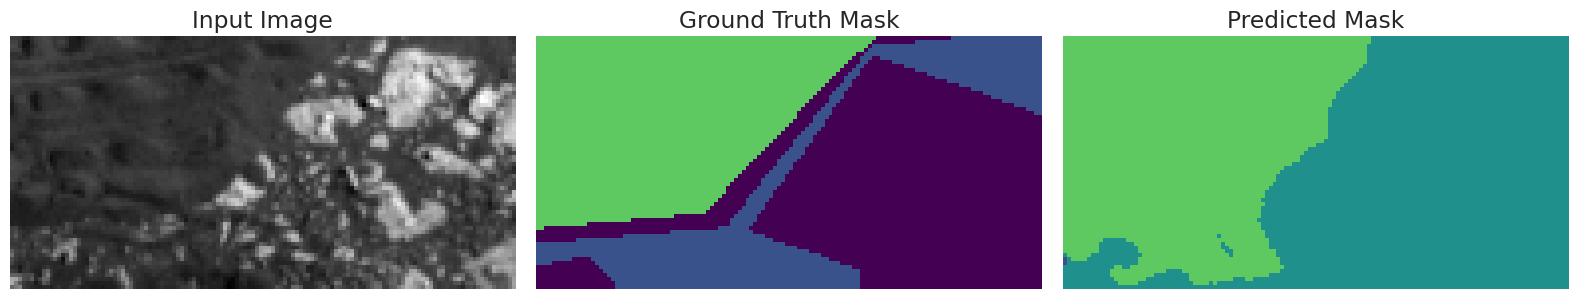

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 443ms/step - final_output_accuracy: 0.6617 - final_output_mean_iou: 0.5417 - loss: 0.0806 - val_final_output_accuracy: 0.6673 - val_final_output_mean_iou: 0.6380 - val_loss: 0.1812 - learning_rate: 5.0000e-05
Epoch 112/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 414ms/step - final_output_accuracy: 0.6719 - final_output_mean_iou: 0.6232 - loss: 0.0783 - val_final_output_accuracy: 0.6617 - val_final_output_mean_iou: 0.6256 - val_loss: 0.1850 - learning_rate: 5.0000e-05
Epoch 113/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 415ms/step - final_output_accuracy: 0.6681 - final_output_mean_iou: 0.5686 - loss: 0.0775 - val_final_output_accuracy: 0.6747 - val_final_output_mean_iou: 0.6505 - val_loss: 0.1684 - learning_rate: 5.0000e-05
Epoch 114/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 413ms/step - final_output_accuracy: 0.6671 - final_output_mean_iou: 0.6134 - loss: 0.0776 - val_final_output_accuracy: 0.6610 - val_final_output_mean_iou: 0.6348 - val_loss: 0.1768 - learning_rate: 5.0000

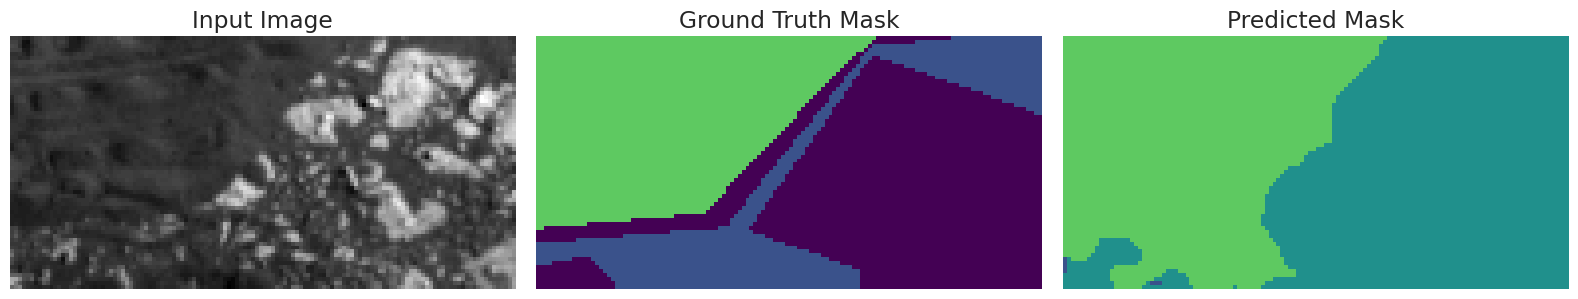

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 439ms/step - final_output_accuracy: 0.6634 - final_output_mean_iou: 0.6019 - loss: 0.0787 - val_final_output_accuracy: 0.6676 - val_final_output_mean_iou: 0.6412 - val_loss: 0.1855 - learning_rate: 5.0000e-05
Epoch 117/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 415ms/step - final_output_accuracy: 0.6631 - final_output_mean_iou: 0.5110 - loss: 0.0801 - val_final_output_accuracy: 0.6662 - val_final_output_mean_iou: 0.6422 - val_loss: 0.1808 - learning_rate: 5.0000e-05
Epoch 118/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - final_output_accuracy: 0.6640 - final_output_mean_iou: 0.5465 - loss: 0.0846 - val_final_output_accuracy: 0.6304 - val_final_output_mean_iou: 0.5807 - val_loss: 0.1741 - learning_rate: 5.0000e-05
Epoch 119/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 439ms/step - final_output_accuracy: 0.6545 - final_output_mean_iou: 0.4918 - loss: 0.0805 - val_final_output_accuracy: 0.6562 - val_final_output_mean_iou: 0.6226 - val_loss: 0.1771 - learning_rate: 5.0000

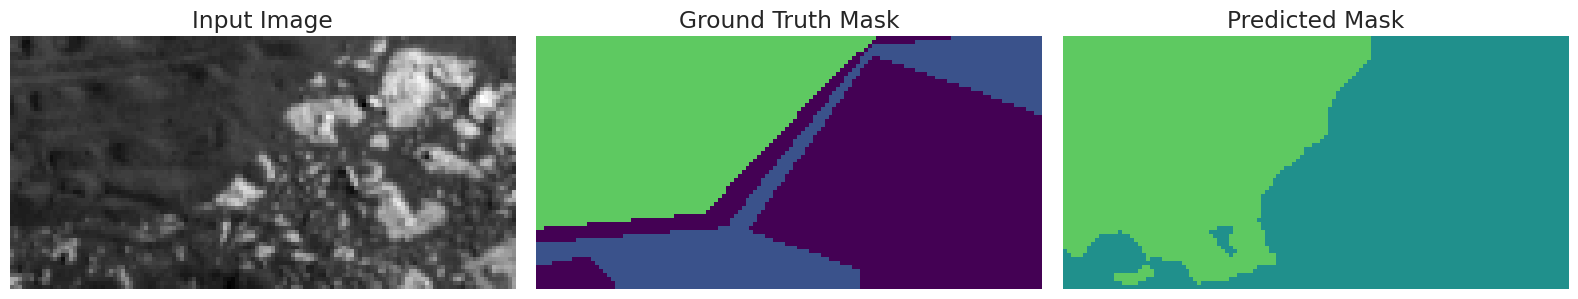

32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 467ms/step - final_output_accuracy: 0.6727 - final_output_mean_iou: 0.5303 - loss: 0.0767 - val_final_output_accuracy: 0.6456 - val_final_output_mean_iou: 0.6150 - val_loss: 0.1741 - learning_rate: 5.0000e-05
Epoch 122/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - final_output_accuracy: 0.6724 - final_output_mean_iou: 0.5654 - loss: 0.0762 - val_final_output_accuracy: 0.6615 - val_final_output_mean_iou: 0.6339 - val_loss: 0.1699 - learning_rate: 5.0000e-05
Epoch 123/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 420ms/step - final_output_accuracy: 0.6636 - final_output_mean_iou: 0.5716 - loss: 0.0789 - val_final_output_accuracy: 0.6564 - val_final_output_mean_iou: 0.6295 - val_loss: 0.1770 - learning_rate: 5.0000e-05
Epoch 124/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 422ms/step - final_output_accuracy: 0.6733 - final_output_mean_iou: 0.6118 - loss: 0.0737 - val_final_output_accuracy: 0.6476 - val_final_output_mean_iou: 0.6225 - val_loss: 0.1864 - learning_rate: 5.0000

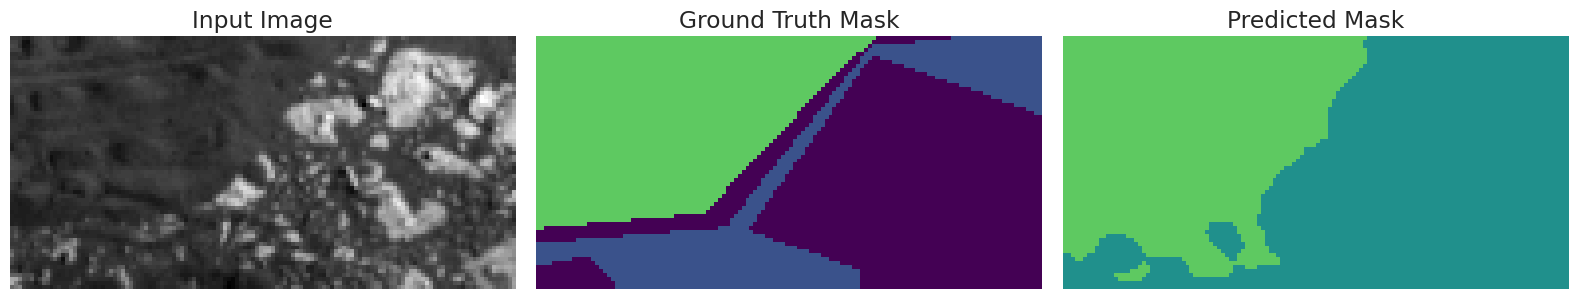

32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 467ms/step - final_output_accuracy: 0.6723 - final_output_mean_iou: 0.6135 - loss: 0.0756 - val_final_output_accuracy: 0.6687 - val_final_output_mean_iou: 0.6576 - val_loss: 0.1750 - learning_rate: 5.0000e-05
Epoch 127/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 398ms/step - final_output_accuracy: 0.6705 - final_output_mean_iou: 0.5104 - loss: 0.0748 - val_final_output_accuracy: 0.6519 - val_final_output_mean_iou: 0.6294 - val_loss: 0.1799 - learning_rate: 5.0000e-05
Epoch 128/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 444ms/step - final_output_accuracy: 0.6699 - final_output_mean_iou: 0.5527 - loss: 0.0755 - val_final_output_accuracy: 0.6671 - val_final_output_mean_iou: 0.6475 - val_loss: 0.1777 - learning_rate: 5.0000e-05
Epoch 129/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - final_output_accuracy: 0.6745 - final_output_mean_iou: 0.5609 - loss: 0.0754 - val_final_output_accuracy: 0.6531 - val_final_output_mean_iou: 0.6325 - val_loss: 0.1819 - learning_rate: 5.0000

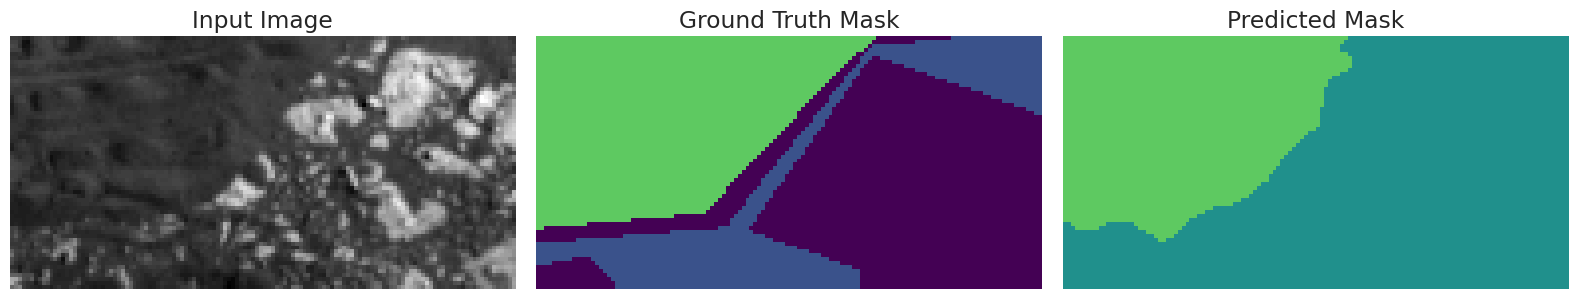

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 444ms/step - final_output_accuracy: 0.6673 - final_output_mean_iou: 0.4918 - loss: 0.0774 - val_final_output_accuracy: 0.6497 - val_final_output_mean_iou: 0.6183 - val_loss: 0.1711 - learning_rate: 5.0000e-05
Epoch 132/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - final_output_accuracy: 0.6649 - final_output_mean_iou: 0.5539 - loss: 0.0770 - val_final_output_accuracy: 0.6573 - val_final_output_mean_iou: 0.6323 - val_loss: 0.1649 - learning_rate: 5.0000e-05
Epoch 133/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 438ms/step - final_output_accuracy: 0.6724 - final_output_mean_iou: 0.5248 - loss: 0.0744 - val_final_output_accuracy: 0.6526 - val_final_output_mean_iou: 0.6176 - val_loss: 0.1742 - learning_rate: 5.0000e-05
Epoch 134/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 405ms/step - final_output_accuracy: 0.6732 - final_output_mean_iou: 0.5100 - loss: 0.0743 - val_final_output_accuracy: 0.6618 - val_final_output_mean_iou: 0.6272 - val_loss: 0.1797 - learning_rate: 5.0000

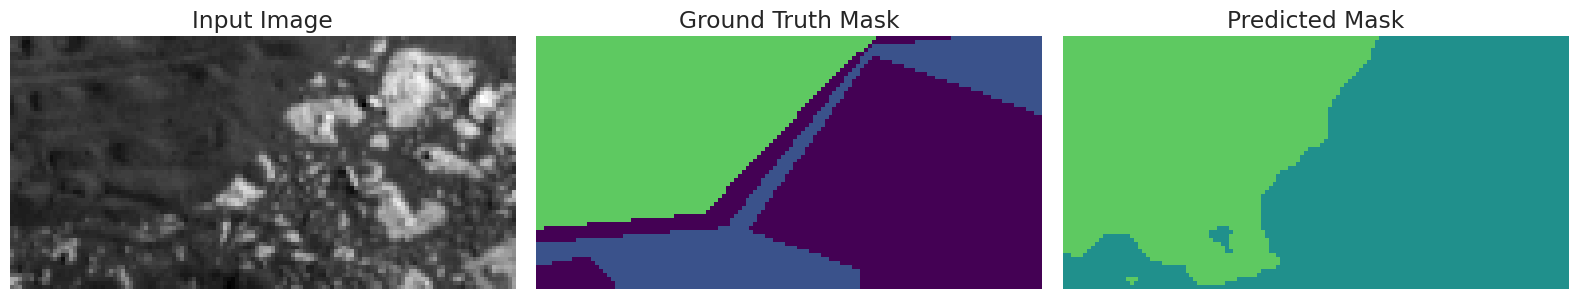

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 466ms/step - final_output_accuracy: 0.6689 - final_output_mean_iou: 0.4980 - loss: 0.0772 - val_final_output_accuracy: 0.6514 - val_final_output_mean_iou: 0.6207 - val_loss: 0.1959 - learning_rate: 5.0000e-05
Epoch 137/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - final_output_accuracy: 0.6725 - final_output_mean_iou: 0.5016 - loss: 0.0743 - val_final_output_accuracy: 0.6347 - val_final_output_mean_iou: 0.5993 - val_loss: 0.1786 - learning_rate: 5.0000e-05
Epoch 138/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 446ms/step - final_output_accuracy: 0.6724 - final_output_mean_iou: 0.5033 - loss: 0.0734 - val_final_output_accuracy: 0.6479 - val_final_output_mean_iou: 0.6183 - val_loss: 0.1742 - learning_rate: 5.0000e-05
Epoch 139/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 420ms/step - final_output_accuracy: 0.6695 - final_output_mean_iou: 0.4989 - loss: 0.0757 - val_final_output_accuracy: 0.5244 - val_final_output_mean_iou: 0.4721 - val_loss: 0.2278 - learning_rate: 5.0000

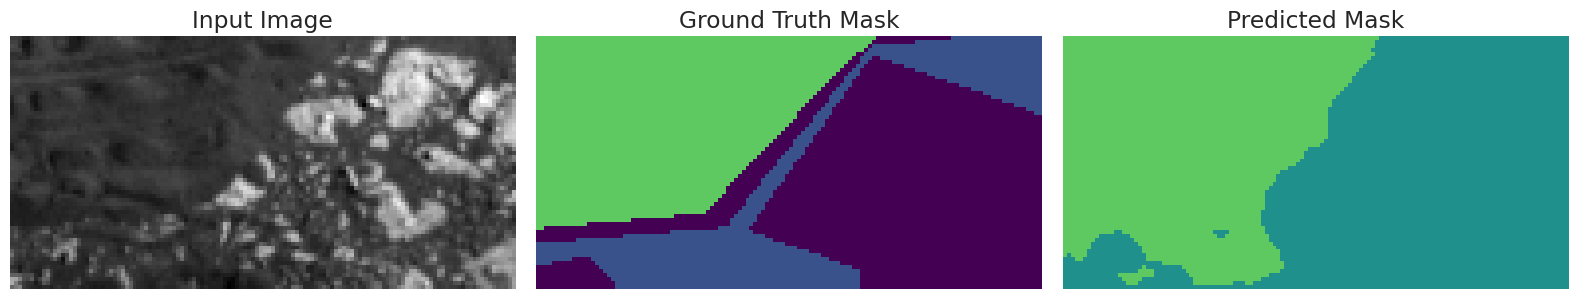

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 447ms/step - final_output_accuracy: 0.6702 - final_output_mean_iou: 0.4938 - loss: 0.0756 - val_final_output_accuracy: 0.6570 - val_final_output_mean_iou: 0.5046 - val_loss: 0.1711 - learning_rate: 5.0000e-05
Epoch 142/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 413ms/step - final_output_accuracy: 0.6775 - final_output_mean_iou: 0.5076 - loss: 0.0710 - val_final_output_accuracy: 0.6639 - val_final_output_mean_iou: 0.6413 - val_loss: 0.1783 - learning_rate: 5.0000e-05
Epoch 143/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 426ms/step - final_output_accuracy: 0.6774 - final_output_mean_iou: 0.5194 - loss: 0.0728 - val_final_output_accuracy: 0.6732 - val_final_output_mean_iou: 0.5255 - val_loss: 0.1969 - learning_rate: 5.0000e-05
Final validation Mean Intersection Over Union: 65.76%
Model saved to model_241214_221348.keras


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback, reduce_lr],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_final_output_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

### Accuracy and mean IoU plots

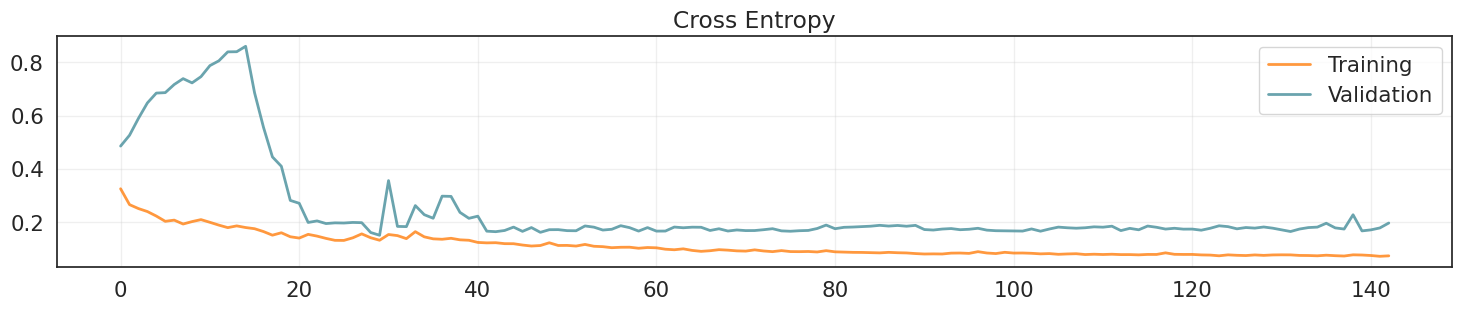

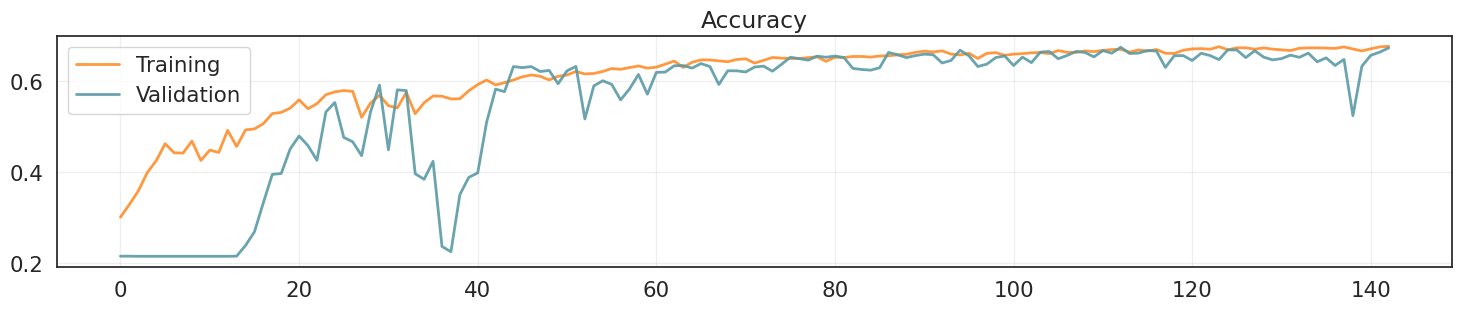

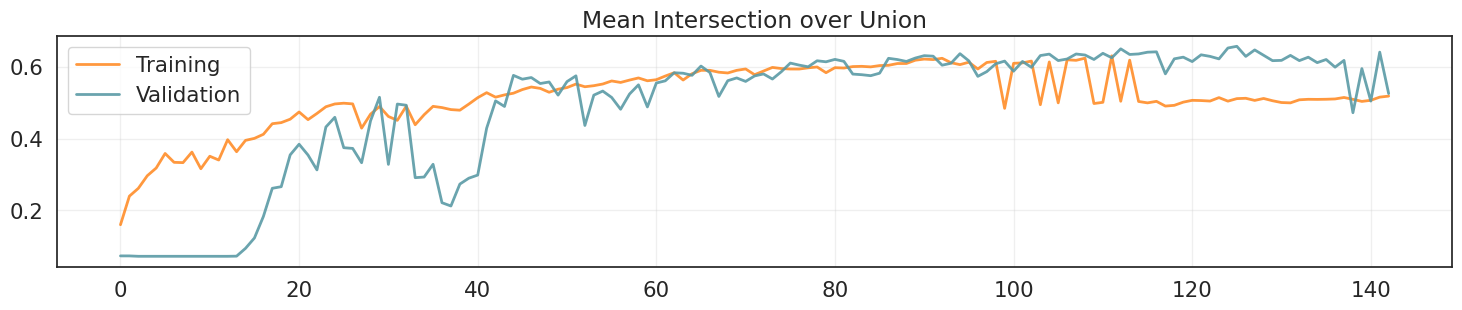

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['final_output_accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_final_output_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['final_output_mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_final_output_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🕹️ Use the Model

In [ ]:
# Load UNet model without compiling
model = tfk.models.load_model(model_filename, compile=False) #compile false because I have a custom metric

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
     metrics=[
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for the main output
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for coarse output 1
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for coarse output 2
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for coarse output 3
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for fine output 1
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for fine output 2
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]  # Metrics for fine output 3
    ]
)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
# model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
# tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [ ]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

Test Accuracy: 0.6577
Test Mean Intersection over Union: 0.5823


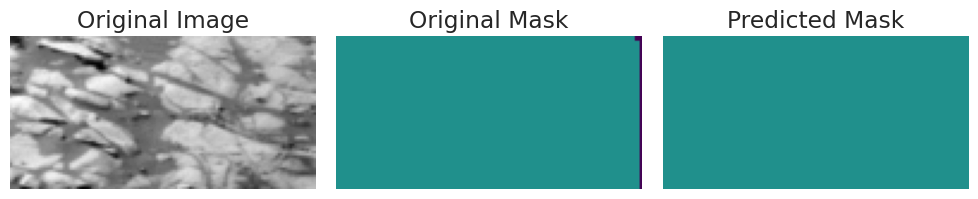

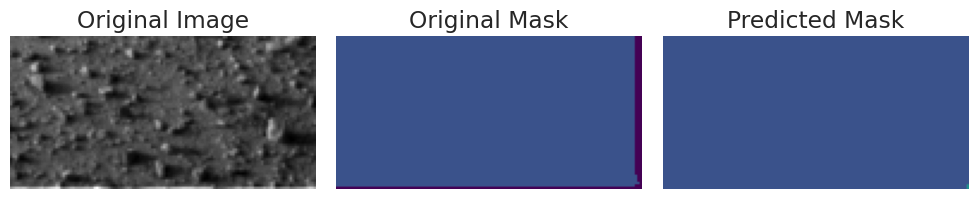

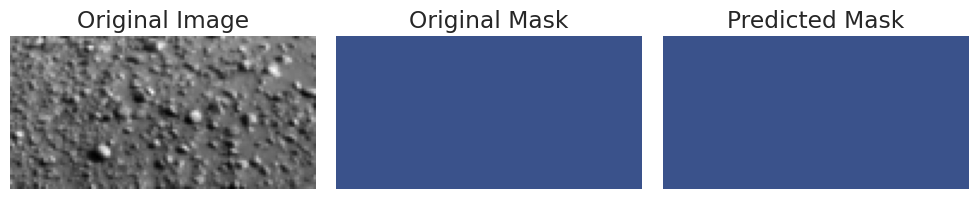

In [ ]:
def plot_triptychs(dataset, model, num_samples=1):
    """
    Plot triptychs (original image, true mask, predicted mask) for samples from a tf.data.Dataset

    Parameters:
    dataset: tf.data.Dataset - The dataset containing image-label pairs
    model: tf.keras.Model - The trained model to generate predictions
    num_samples: int - Number of samples to plot
    """
    # Take samples from the dataset
    samples = dataset.take(num_samples)
    plot_count=0

    for images, labels in samples:
        # If we have a batch, take the first example
        #if len(images.shape) == 4:  # Batch of images
        #    images = images[0:1]
        #    labels = labels[0:1]


        # Generate predictions
        pred = model.predict(images, verbose=0)[0]
        pred = tf.math.argmax(pred, axis=-1)

        # Create colormap based on number of classes in labels
        labels_np = labels.numpy()
        #num_classes = len(np.unique(labels_np))
        num_classes= 5
        colormap = create_segmentation_colormap(num_classes)


        for i in range(images.shape[0]):
            if plot_count >= num_samples:
                break  # Stop if we've plotted enough samples

            # Create figure with subplots
            fig, axes = plt.subplots(1, 3, figsize=(10, 3))

            # Plot original image
            axes[0].set_title("Original Image")
            axes[0].imshow(images[i], cmap='gray')
            axes[0].axis('off')

            # Plot original mask
            axes[1].set_title("Original Mask")
            colored_label = apply_colormap(labels[i], colormap)
            axes[1].imshow(colored_label)
            axes[1].axis('off')

            # Plot predicted mask
            axes[2].set_title("Predicted Mask")
            colored_pred = apply_colormap(pred[i], colormap)
            axes[2].imshow(colored_pred)
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

            plot_count += 1  # Increment plot counter

# Example usage:
# Plot three random samples
plot_triptychs(test_dataset, model, num_samples=3)

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
model = tfk.models.load_model(model_filename,compile=False)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
     metrics=[
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for the main output
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for coarse output 1
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for coarse output 2
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for coarse output 3
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for fine output 1
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])], # Metrics for fine output 2
        ["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]  # Metrics for fine output 3
    ]
)

print(f"Model loaded from {model_filename}")

Model loaded from model_241214_221348.keras


In [ ]:
X_test = X_test / 255.0
X_test = X_test.astype(np.float32)

# Define prediction batch size
prediction_batch_size = 1024

# Initialize a list to store predictions
all_preds = []

# Predict in batches
for i in range(0, len(X_test), prediction_batch_size):
    # Select the batch
    X_batch = X_test[i:i + prediction_batch_size]

    # Make predictions for the current batch
    batch_preds = model.predict(X_batch)[0]  # Only take the final predictions

    # Convert to class labels
    batch_preds = np.argmax(batch_preds, axis=-1)

    # Append to the list of predictions
    all_preds.append(batch_preds)

# Concatenate all predictions into a single array
all_preds = np.concatenate(all_preds, axis=0)

# Check final shape
print(f"Predictions shape: {all_preds.shape}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(all_preds)
submission_df.to_csv(submission_filename, index=False)

**Now, before running the following command, you have to download the `.csv` file from your Drive folder.**



In [ ]:
# Delete the created files on Drive (the submission csv is alreay in your local Download folder)
!rm model.png *.keras *.csv